# DSI-18 Project 3: Sub-Reddits Classification Analysis

## Problem Statement

Training a classification model on r/excel and r/vba to better match queries for Excel & VBA Support Company and eventually achieve an annual savings based on man-hour costs for the company. 

## Executive Summary

**Background**<br>
Excel & VBA Support Company is a company that provides specialized support for Microsoft Excel & VBA users. Users post their problem in a query box and a specific (Excel or VBA) specialists are assigned to attend the query and reply (in real-time). <br>

**Issue**<br>
However, the current setup requires manual labelling of the query by users (with manual random checks) on whether it is an Excel or VBA issue and time is wasted if it is mis-classified. Mis-classification is an issue as VBA requires a more specialized product knowledge and product specialists supporting Excel are not necessarily able to support VBA queries. However, the inverse is not true, as VBA product specialists are more likely able to support Excel queries. <br>

Assuming the company receives 1000 Excel queries per day but out of these, 20% are actually VBA queries. Further assuming that redirecting these wrongly classified queries will waste an additional 10 mins (or 1/6th man-hour) for searching and matching to the correct product specialist, there is wastage of 2000 mins (~ 30 man-hours) daily just because the query was mis-classified. Assuming a hypothetical man-hour cost of 50 dollars per man-hour, there is a wastage of 0.5 million dollars per year just due to the mis-classification. <br>

Our model trains on the r/excel and r/vba sub-reddits so that it is able to differentiate among the 2 classes and classify the queries accordingly. We imported the sub-reddits and combined the title and text of each post to form the training and validation sets. Our models consisted of a variety of classification models including, Logistic Regression, Naive Bayes, Random Forests and Support Vectors to see which gives us the lowest false negatives (predicted to be excel query but was in fact a vba query).

## Contents:

- [Scraping the 2 sub reddits](#Scraping-the-2-sub-reddits)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Pre-processing](#Pre-processing)
- [Running Classifier Models on Default Settings](#Running-Classifier-Models-on-Default-Settings)
- [Tuning Hyper-Parameters and GridSearch](#Tuning-Hyper-Parameters-and-GridSearch)
- [Best Model Selection and Evaluation](#Best-Model-Selection-and-Evaluation)
- [Conclusion & Post Evaluation](#Conclusion-&-Post-Evaluation)



**Importing Tools**

In [144]:
import pandas as pd
pd.options.display.max_columns = 2000 # number of columns to display
pd.options.display.max_rows = 1000 # number of rows to display
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn') # set plt style
%matplotlib inline

# for cleaning our texts
from bs4 import BeautifulSoup 
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# for generating word clouds
from collections import Counter 
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image, ImageFont

# importing models and pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# import scoring metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix



## Scraping the 2 sub reddits

The sub reddits was scrap using the reddit API in an earlier [jupyter notebook](./reddit_scraping.ipynb) and the returned raw results is saved in the dataset folder. Let's proceed to import the raw posts and explore the 2 sub reddits.

In [145]:
excel_df = pd.read_csv('..\\datasets\\excel_26_nov.csv')
vba_df = pd.read_csv('..\\datasets\\vba_26_nov.csv')

## Exploratory Data Analysis

In [146]:
excel_df.shape

(1964, 105)

In [147]:
vba_df.shape

(1993, 105)

In [148]:
excel_df.drop_duplicates(inplace=True)
excel_df.reset_index(drop=True, inplace=True)

In [149]:
vba_df.drop_duplicates(inplace=True)
vba_df.reset_index(drop=True, inplace=True)

In [150]:
excel_df.drop_duplicates(subset = ['title', 'selftext', 'author_fullname'], keep='first', inplace=True)

In [151]:
vba_df.drop_duplicates(subset = ['title', 'selftext', 'author_fullname'], keep='first', inplace=True)

In [152]:
vba_df['link_flair_css_class'].value_counts()

solved           412
unsolved         316
discussion       134
showntell         16
recap             10
unsolved1          9
protip             4
codereview         2
advertisement      1
Name: link_flair_css_class, dtype: int64

In [153]:
excel_df['link_flair_css_class'].value_counts()

solvedpoint       274
unsolved          196
waitingonop       138
solvedcase         93
notsolvedcase      57
discussioncase     35
protip              4
showandtell         4
removed             2
abandoned           2
challenge           2
Name: link_flair_css_class, dtype: int64

We noticed also that our vba has a section called 'link_flair_css_class' which has 2 categories that we do not particularly want: 'recap' and 'advertisement'. 'Recap' are not pure queries and just a very short summary of some of the posts made for the past week, similarly, 'advertisement' would probably not help our model to train. Hence, we shall remove instances of these in vba_df: 

In [154]:
vba_df = vba_df[(vba_df.link_flair_css_class != 'recap')]
vba_df = vba_df[(vba_df.link_flair_css_class != 'advertisement')]

In [155]:
vba_df['link_flair_css_class'].value_counts() # check

solved        412
unsolved      316
discussion    134
showntell      16
unsolved1       9
protip          4
codereview      2
Name: link_flair_css_class, dtype: int64

In [156]:
print(excel_df.shape)
print(vba_df.shape)

(807, 105)
(935, 105)


Our vba dataset had a lot more duplicates, let's check the null values next. 

In [157]:
excel_df.isnull().sum()

approved_at_utc                  807
subreddit                          0
selftext                           0
author_fullname                    1
saved                              0
mod_reason_title                 807
gilded                             0
clicked                            0
title                              0
link_flair_richtext                0
subreddit_name_prefixed            0
hidden                             0
pwls                               0
link_flair_css_class               0
downs                              0
top_awarded_type                 807
hide_score                         0
name                               0
quarantine                         0
link_flair_text_color              0
upvote_ratio                       0
author_flair_background_color    756
subreddit_type                     0
ups                                0
total_awards_received              0
media_embed                        0
author_flair_template_id         756
i

In [158]:
vba_df.isnull().sum()

approved_at_utc                  935
subreddit                          0
selftext                           3
author_fullname                    3
saved                              0
mod_reason_title                 935
gilded                             0
clicked                            0
title                              0
link_flair_richtext                0
subreddit_name_prefixed            0
hidden                             0
pwls                               0
link_flair_css_class              42
downs                              0
top_awarded_type                 935
hide_score                         0
name                               0
quarantine                         0
link_flair_text_color              0
upvote_ratio                       0
author_flair_background_color    865
subreddit_type                     0
ups                                0
total_awards_received              0
media_embed                        0
author_flair_template_id         865
i

We are mostly concern about 'title' and 'selftext' columns as this is where the title and main body of the text are. Thus if there are null values in other columns, it will not be detrimental to our analysis. <br>

Consequently, we will not try to look for ways to fill values for most of these colummns as they will not be necessary in our analysis.<br>

Before we jump into analysing trends of the posts, since r/excel and r/vba are very similar, there might be wrong postings that ought to be in one sub reddit but was posted in the other. In fact, since it can be said that r/vba is a specialized sub-set of r/excel, there is a high possibility that posts will appear in r/excel asking for r/vba information (which is what our problem statement identiied). However, and intuitively, posts asking for help in excel appearing in r/vba should be rare. Thus, we would like to remove instances of vba in r/excel but **not** instances of excel in r/vba , so that our 2 sub reddits can better reflect the actual sub reddit they are in. <br>

Looping this back to our problem statement, we are particularly concern regarding posts asking for help for vba is posted in r/excel as the help desk personnel for r/excel might not have the specialzed knowledge to solve the vba issue. The excel personnel will then have to divert the query to the correct vba personnel, wasting time and resources for both the company and client.

In [159]:
# converting the title to lower case
excel_df['title'] = excel_df['title'].str.lower()
vba_df['title'] = vba_df['title'].str.lower()

In [160]:
# look for possibility of cross/wrong postings
print(len(excel_df.loc[excel_df['title'].str.contains('vba')]))
excel_df.loc[excel_df['title'].str.contains('vba')]


46


approved_at_utc subreddit  \
7                NaN     excel   
15               NaN     excel   
30               NaN     excel   
35               NaN     excel   
67               NaN     excel   
70               NaN     excel   
71               NaN     excel   
82               NaN     excel   
96               NaN     excel   
101              NaN     excel   
114              NaN     excel   
132              NaN     excel   
134              NaN     excel   
137              NaN     excel   
147              NaN     excel   
168              NaN     excel   
216              NaN     excel   
220              NaN     excel   
237              NaN     excel   
268              NaN     excel   
310              NaN     excel   
356              NaN     excel   
458              NaN     excel   
462              NaN     excel   
479              NaN     excel   
509              NaN     excel   
519              NaN     excel   
529              NaN     excel   
551              NaN     excel   
569              NaN     excel   
576              NaN     excel   
578              NaN     excel   
630              NaN     excel   
640              NaN     excel   
646              NaN     excel   
658              NaN     excel   
660              NaN     excel   
677              NaN     excel   
688              NaN     excel   
695              NaN     excel   
704              NaN     excel   
710              NaN     excel   
751              NaN     excel   
755              NaN     excel   
768              NaN     excel   
780              NaN     excel   

                                              selftext author_fullname  saved  \
7    I have data which needs to be entered in a tab...     t2_4eib9zl5  False   
15   Hi,\n\nIm trying to write some VBA code. \n\nS...        t2_souw7  False   
30   Hi,\n\nI have this code so far:\n\n    On Erro...      t2_4os0jb0  False   
35   I know I can do something like this :\n\n    C...     t2_23kb0vj0  False   
67   Relatively new to VBA\n\nTried googling it, bu...     t2_1h34de4r  False   
70   Here is the situation:\n\nI have to send 40 it...     t2_7y3w9ktn  False   
71   Hi,\n\nI've found this Macro for copying and p...     t2_4pdxgwro  False   
82   Hello,\n\nI have a weekly report for work that...     t2_2i2jwkrl  False   
96   Good day all. I am working on a way to automat...        t2_l5il2  False   
101  Hello Everyone,\n\nI currently have some data ...        t2_yhmi2  False   
114  Does anyone have ideas on the best way to refr...       t2_136hrd  False   
132  I have a cell that has for a formula is =vlook...     t2_136170ko  False   
134  How should I go about running the macro on the...     t2_4mrnu3hv  False   
137  I am only trying to affect sheet 5, but why is...     t2_4mrnu3hv  False   
147  Somewhat new to VBA, so anything helps! \n\nI ...     t2_4yy8w4wf  False   
168  Hi, I have the code:\n\n`For i = 1 To loopcoun...     t2_4bg26tbc  False   
216  I am new to macro and really appreciate if som...     t2_4mrnu3hv  False   
220   \n\nHello, I am an macro newbie, so can someb...     t2_4mrnu3hv  False   
237  I want to make a macro that filters a column f...     t2_23kb0vj0  False   
268  When refreshing stock data using VBA code, is ...     t2_712ccvxm  False   
310  I want to delete rows in column B that contain...     t2_4mrnu3hv  False   
356  Hi\n\nI have a macro that brings up an InputBo...        t2_4i37v  False   
458  Is it possible to have a macro look at a list ...      t2_w81f6a0  False   
462  Hi all,\n\nDoes anyone know which VBA course o...     t2_5hfhnqza  False   
479  I am so close to figuring this code out. I hav...     t2_7v3geslo  False   
509  Hello,\n\nI'm very new to VBA, and trying to f...        t2_cwztr  False   
519  Hello,\n\nIn my first foray into VBA, I used t...        t2_66ccp  False   
529  Input data: a range or table with 8 Japanese w...       t2_12bmii  False   
551  Could someone please step me through how this ...   

In [161]:
vba_df.loc[vba_df['title'].str.contains('excel')]

approved_at_utc subreddit  \
1                NaN       vba   
3                NaN       vba   
5                NaN       vba   
7                NaN       vba   
12               NaN       vba   
15               NaN       vba   
18               NaN       vba   
21               NaN       vba   
25               NaN       vba   
28               NaN       vba   
29               NaN       vba   
31               NaN       vba   
33               NaN       vba   
37               NaN       vba   
38               NaN       vba   
39               NaN       vba   
41               NaN       vba   
43               NaN       vba   
50               NaN       vba   
53               NaN       vba   
58               NaN       vba   
60               NaN       vba   
64               NaN       vba   
65               NaN       vba   
71               NaN       vba   
73               NaN       vba   
77               NaN       vba   
83               NaN       vba   
86               NaN       vba   
87               NaN       vba   
90               NaN       vba   
91               NaN       vba   
97               NaN       vba   
99               NaN       vba   
100              NaN       vba   
102              NaN       vba   
106              NaN       vba   
107              NaN       vba   
109              NaN       vba   
118              NaN       vba   
121              NaN       vba   
133              NaN       vba   
135              NaN       vba   
141              NaN       vba   
143              NaN       vba   
147              NaN       vba   
148              NaN       vba   
150              NaN       vba   
152              NaN       vba   
154              NaN       vba   
157              NaN       vba   
161              NaN       vba   
168              NaN       vba   
169              NaN       vba   
170              NaN       vba   
177              NaN       vba   
179              NaN       vba   
180              NaN       vba   
181              NaN       vba   
182              NaN       vba   
186              NaN       vba   
187              NaN       vba   
193              NaN       vba   
194              NaN       vba   
195              NaN       vba   
196              NaN       vba   
197              NaN       vba   
198              NaN       vba   
204              NaN       vba   
205              NaN       vba   
208              NaN       vba   
211              NaN       vba   
213              NaN       vba   
214              NaN       vba   
217              NaN       vba   
218              NaN       vba   
226              NaN       vba   
227              NaN       vba   
228              NaN       vba   
234              NaN       vba   
237              NaN       vba   
239              NaN       vba   
240              NaN       vba   
241              NaN       vba   
243              NaN       vba   
244              NaN       vba   
245              NaN       vba   
252              NaN       vba   
254              NaN       vba   
255              NaN       vba   
260              NaN       vba   
267              NaN       vba   
279              NaN       vba   
282              NaN       vba   
284              NaN       vba   
287              NaN       vba   
294              NaN       vba   
296              NaN       vba   
298              NaN       vba   
300              NaN       vba   
302              NaN       vba   
310              NaN       vba   
311              NaN       vba   
314              NaN       vba   
320              NaN       vba   
326              NaN       vba   
328              NaN       vba   
338              NaN       vba   
339              NaN       vba   
344              NaN       vba   
350              NaN       vba   
351              NaN       vba   
353              NaN       vba   
354              NaN       vba   
358              NaN       vba   
362              NaN       vba   
363              NaN       

We observed that there were 46 posts in the r/excel reddit that were actually posts regarding vba, constituting almost 6% of the total r/excel posts. <br>

Similarly, we observed that postings in r/excel regarding vba are in fact questions about vba whereas search in r/vbas for 'excel' keywords return posting of words with 'excel vba' in them. Hence, these are likely to be about vba and not excel in general. <br>

As discussed, we shall remove the postings of vba from r/excel and keep postings of excel in r/vba:

In [162]:
excel_df = excel_df[~excel_df.title.str.contains('vba')]

In [163]:
# checking if there are any postings of vba in the selftext of r/excel 
print(len(excel_df.loc[excel_df['selftext'].str.contains('vba')]))
excel_df.loc[excel_df['selftext'].str.contains('vba')]


9


approved_at_utc subreddit  \
109              NaN     excel   
133              NaN     excel   
375              NaN     excel   
405              NaN     excel   
411              NaN     excel   
559              NaN     excel   
594              NaN     excel   
611              NaN     excel   
806              NaN     excel   

                                              selftext author_fullname  saved  \
109  Hi guys,\n\nI'm trying to build a work flow th...     t2_1h8mc5ut  False   
133  i know that i can go to to data -&gt; get data...        t2_d4nga  False   
375  So after many, many, many hours I finally figu...        t2_hw3ze  False   
405  Hello! I work for a small manufacturing compan...      t2_x2ps1sv  False   
411  I have been working with Excel for the last 10...        t2_zq5mp  False   
559  Hi all, \n\nHoping for you a little vba help t...     t2_4hv31tbo  False   
594  Hey okey I got this vba code that works great....        t2_am0zr  False   
611  Hi I’m looking for an intermediate course in e...        t2_rd7ut  False   
806  So I got vba code that works to call shell and...        t2_am0zr  False   

     mod_reason_title  gilded  clicked  \
109               NaN       0    False   
133               NaN       0    False   
375               NaN       0    False   
405               NaN       0    False   
411               NaN       0    False   
559               NaN       0    False   
594               NaN       0    False   
611               NaN       0    False   
806               NaN       0    False   

                                                 title  \
109  automatically changing cell value based on ano...   
133                           data from sql query file   
375  happy! i conquered conditional formatting for ...   
405               transposing awkwardly formatted data   
411  is there a glass ceiling for a career as excel...   
559  macro to jump to cell in same row as specific ...   
594  how can i check the latest number in one colum...   
611  looking for a suggestion for an in-person-type...   
806  how do i use environ"username" when calling sh...   

                    link_flair_richtext subreddit_name_prefixed  hidden  pwls  \
109    [{'e': 'text', 't': 'unsolved'}]                 r/excel   False     6   
133    [{'e': 'text', 't': 'unsolved'}]                 r/excel   False     6   
375  [{'e': 'text', 't': 'Discussion'}]                 r/excel   False     6   
405      [{'e': 'text', 't': 'solved'}]                 r/excel   False     6   
411  [{'e': 'text', 't': 'Discussion'}]                 r/excel   False     6   
559      [{'e': 'text', 't': 'solved'}]                 r/excel   False     6   
594      [{'e': 'text', 't': 'solved'}]                 r/excel   False     6   
611   [{'e': 'text', 't': 'Education'}]                 r/excel   False     6   
806      [{'e': 'text', 't': 'solved'}]                 r/excel   False     6   

    link_flair_css_class  downs  top_awarded_type  hide_score       name  \
109             unsolved      0               NaN       False  t3_k0oljz   
133             unsolved      0               NaN       False  t3_k0h48b   
375       discussioncase      0               NaN       False  t3_jyhx79   
405          solvedpoint      0               NaN       False  t3_jycbj0   
411       discussioncase      0               NaN       False  t3_jxpltx   
559          solvedpoint      0               NaN       False  t3_jx7ce7   
594          solvedpoint      0               NaN       False  t3_jx0d1c   
611       discussioncase      0               NaN       False  t3_jwrj93   
806          solvedpoint      0               NaN       False  t3_jvsn6g   

     quarantine link_flair_text_color  upvote_ratio  \
109       False                 light          0.67   
133       False                 light          0.67   
375       False                 light          0.82   
405       False                 light          0.76   
411 

We observed a further 9 posts that made references to vba in r/excel selftext and shall remove these as well:

In [164]:
excel_df = excel_df[~excel_df.selftext.str.contains('vba')]

In [165]:
print(excel_df.shape)  #checking that 111 rows were removed
# reseting index
excel_df.reset_index(drop=True, inplace=True)

(752, 105)


In [166]:
print(excel_df.shape)
print(vba_df.shape)

(752, 105)
(935, 105)


Next, let's find out the timing of the posts that are in our 2 sub-reddits:

In [167]:
# converting created_utc to datetime
excel_df['datetime'] = pd.to_datetime(excel_df['created_utc'], unit='s')

In [168]:
excel_df['datetime']

0     2020-11-26 04:55:29
1     2020-11-26 09:33:55
2     2020-11-26 07:24:47
3     2020-11-26 11:18:26
4     2020-11-26 13:42:26
5     2020-11-26 09:34:38
6     2020-11-26 13:07:56
7     2020-11-26 09:11:14
8     2020-11-26 04:11:15
9     2020-11-26 12:38:11
10    2020-11-26 12:32:43
11    2020-11-25 10:31:57
12    2020-11-26 11:55:02
13    2020-11-26 11:47:53
14    2020-11-26 11:29:18
15    2020-11-25 23:25:06
16    2020-11-26 11:01:45
17    2020-11-26 10:38:13
18    2020-11-26 10:19:33
19    2020-11-26 10:09:10
20    2020-11-26 10:06:15
21    2020-11-26 09:33:37
22    2020-11-26 09:08:16
23    2020-11-26 08:35:07
24    2020-11-26 08:25:10
25    2020-11-26 08:18:54
26    2020-11-26 08:17:42
27    2020-11-26 08:09:46
28    2020-11-26 07:53:26
29    2020-11-26 07:48:59
30    2020-11-25 14:26:01
31    2020-11-25 23:50:18
32    2020-11-26 01:56:50
33    2020-11-26 01:37:42
34    2020-11-25 21:39:01
35    2020-11-26 01:15:01
36    2020-11-25 18:43:05
37    2020-11-25 15:13:30
38    2020-1

In [169]:
vba_df['datetime'] = pd.to_datetime(vba_df['created_utc'], unit='s')

In [170]:
vba_df['datetime']

0     2020-11-20 00:11:56
1     2020-11-26 13:04:56
2     2020-11-25 22:38:09
3     2020-11-26 09:27:11
4     2020-11-26 06:11:02
5     2020-11-26 02:55:27
6     2020-11-25 12:38:54
7     2020-11-25 22:37:32
8     2020-11-25 21:42:38
9     2020-11-25 20:35:34
10    2020-11-25 18:35:30
11    2020-11-25 18:21:33
12    2020-11-25 16:02:35
13    2020-11-25 15:43:01
14    2020-11-25 15:39:59
15    2020-11-25 15:36:16
16    2020-11-25 15:07:54
17    2020-11-24 20:03:23
18    2020-11-25 12:13:55
19    2020-11-25 07:40:43
20    2020-11-24 23:33:58
21    2020-11-24 23:26:56
22    2020-11-24 20:49:47
23    2020-11-24 22:42:19
24    2020-11-24 18:06:15
25    2020-11-24 21:19:02
26    2020-11-24 15:18:41
27    2020-11-24 16:49:59
28    2020-11-24 16:25:23
29    2020-11-24 13:21:35
30    2020-11-24 13:03:40
31    2020-11-23 22:23:35
32    2020-11-24 04:05:29
33    2020-11-24 02:40:12
34    2020-11-24 03:48:21
35    2020-11-24 02:53:59
36    2020-11-23 23:07:25
37    2020-11-23 21:08:44
38    2020-1

In [171]:
print('Earliest post in Excel sub-reddit is ' + str(min(excel_df['datetime'])))
print('Latest post in Excel sub-reddit is ' + str(max(excel_df['datetime'])))

Earliest post in Excel sub-reddit is 2020-11-16 21:03:31
Latest post in Excel sub-reddit is 2020-11-26 13:42:26


In [172]:
print('Earliest post in VBA sub-reddit is ' + str(min(vba_df['datetime'])))
print('Latest post in VBA sub-reddit is ' + str(max(vba_df['datetime'])))

Earliest post in VBA sub-reddit is 2020-07-31 09:38:12
Latest post in VBA sub-reddit is 2020-11-26 13:04:56


The excel sub-reddit is certainly more active as it has a wider application and thus higher user base. The earliest post was just 10 days ago from 26 Nov 2020, the date we pulled our data. <br>

Conversely, the vba sub reddit is certainly more specialized and thus have a lower user base. The earliest post was almost 4 months ago on 31 Jul 2020.

In [173]:
excel_df['day'] = pd.DatetimeIndex(excel_df['datetime']).day

In [174]:
vba_df['month'] = pd.DatetimeIndex(vba_df['datetime']).month
vba_df['day'] = pd.DatetimeIndex(vba_df['datetime']).day

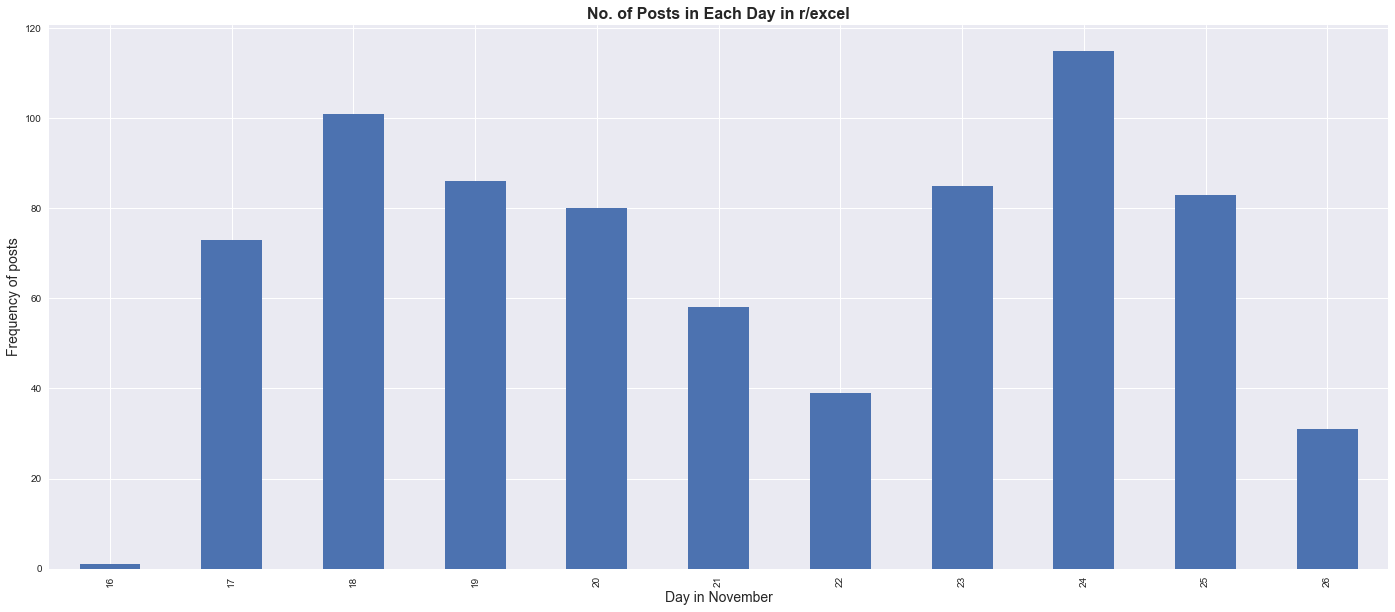

In [175]:
ax = excel_df.groupby(['day']).title.count().plot(kind='bar', figsize=(24,10))
ax.set_ylabel('Frequency of posts', fontsize=14)
ax.set_xlabel('Day in November', fontsize=14)
ax.set_title('No. of Posts in Each Day in r/excel', fontsize=16, fontweight='bold')
plt.show()

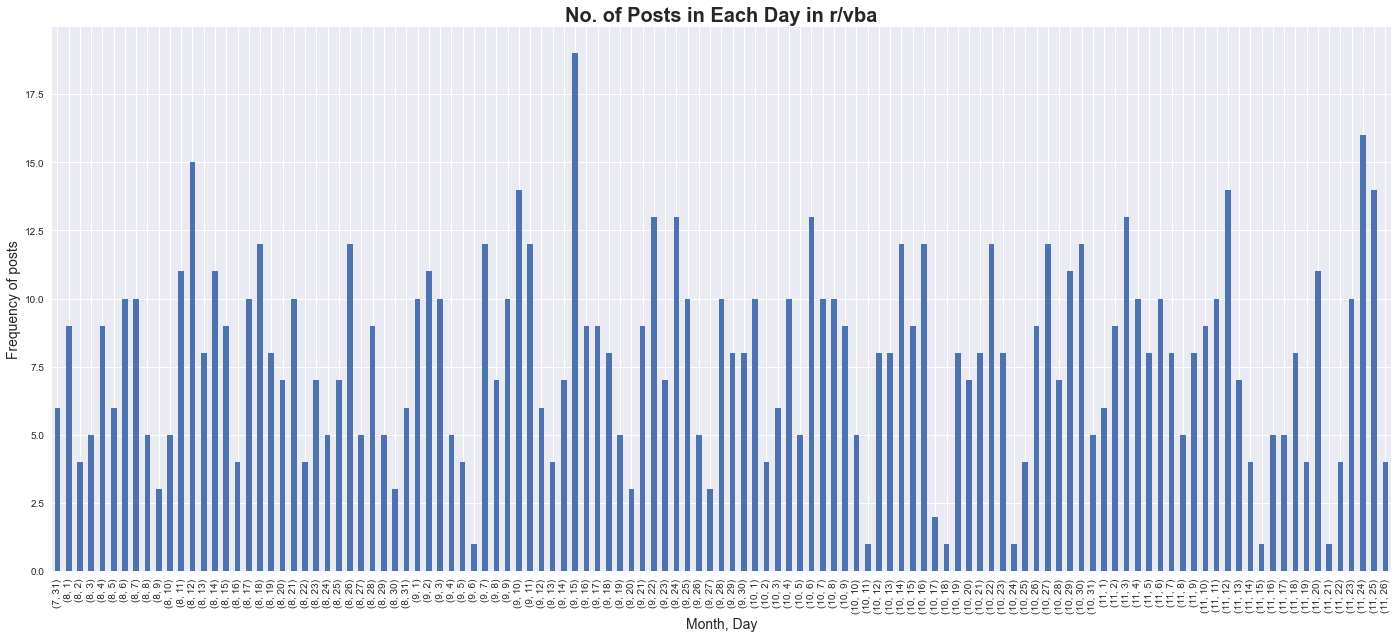

In [176]:
ax = vba_df.groupby(['month', 'day']).title.count().plot(kind='bar', figsize=(24,10))
ax.set_ylabel('Frequency of posts', fontsize=14)
ax.set_xlabel('Month, Day', fontsize=14)
ax.set_title('No. of Posts in Each Day in r/vba', fontsize=20, fontweight='bold')
plt.show()

For the excel sub-reddit, the number of posts ranges from 100 to about 350, with daily postings, hence our dataset of about 1,900 posts only ranges back to 16 Nov 2020. <br>

On the other hand, posts in vba sub-reddit are also made daily but ranges from the low of 1 to max of about 23, far fewer than r/excel. The r/vba dataset thus contains posts from as far back as 31 Jul 2020. <br>

Next, let's look at the length of the title and post to see if there are any trends:

In [177]:
print(excel_df['selftext'].isnull().sum())
print(excel_df['title'].isnull().sum())
print(vba_df['selftext'].isnull().sum())
print(vba_df['title'].isnull().sum())

0
0
3
0


In [178]:
# filling empty cells with empty strings
vba_df['selftext'].fillna('', inplace=True)

In [179]:
print(excel_df['title'][0])
len(excel_df['title'][0])

print cell when populated


25

In [180]:
excel_df['title_len'] = [len(i) for i in excel_df['title']]
excel_df['text_len'] = [len(i) for i in excel_df['selftext']]

In [181]:
vba_df['title_len'] = [len(i) for i in vba_df['title']]
vba_df['text_len'] = [len(i) for i in vba_df['selftext']]

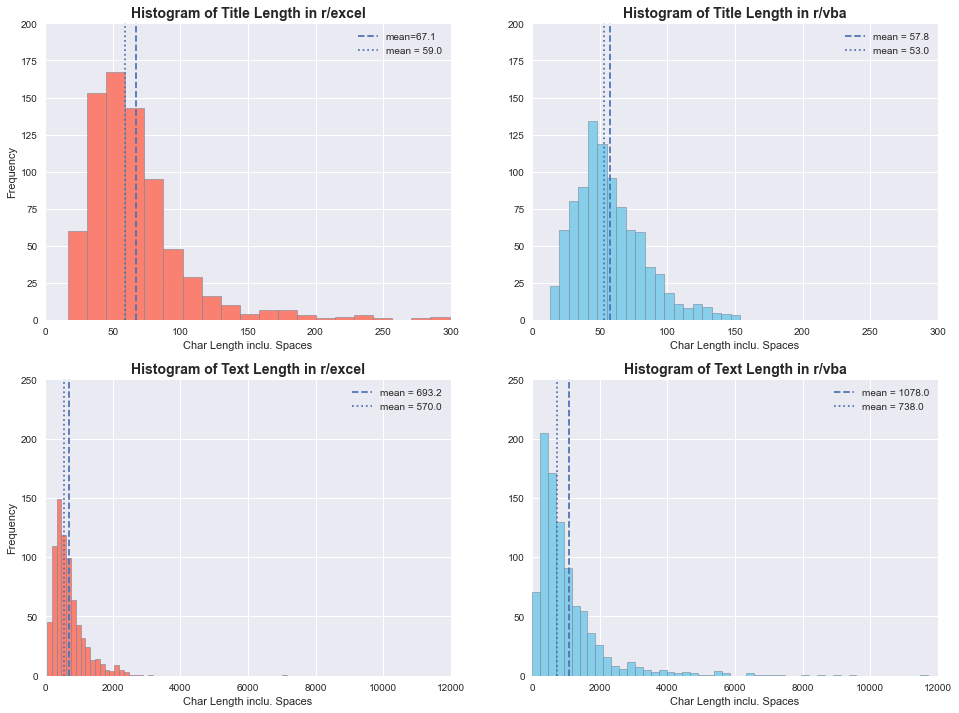

In [182]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12))
ax = ax.ravel()

ax[0].hist(excel_df['title_len'], bins=20, color='salmon', edgecolor='slategray', linewidth=0.5)
ax[0].axvline(excel_df['title_len'].mean(), label=f"mean={round(excel_df['title_len'].mean(),1)}", ls='--')
ax[0].axvline(excel_df['title_len'].median(), label=f"mean = {round(excel_df['title_len'].median(),1)}", ls=':')
ax[0].set_title('Histogram of Title Length in r/excel', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Frequency')

ax[1].hist(vba_df['title_len'], bins=20, color='skyblue', edgecolor='slategray', linewidth=0.5)
ax[1].axvline(vba_df['title_len'].mean(), label=f"mean = {round(vba_df['title_len'].mean(),1)}", ls='--')
ax[1].axvline(vba_df['title_len'].median(), label=f"mean = {round(vba_df['title_len'].median(),1)}", ls=':')
ax[1].set_title('Histogram of Title Length in r/vba', fontsize=14, fontweight='bold')


for i in (0,1):
    ax[i].set_ylim([0,200])
    ax[i].set_xlim([0,300])
    ax[i].set_xlabel('Char Length inclu. Spaces')
    ax[i].legend()
    

ax[2].hist(excel_df['text_len'], bins=50, color='salmon', edgecolor='slategray', linewidth=0.5)
ax[2].axvline(excel_df['text_len'].mean(), label=f"mean = {round(excel_df['text_len'].mean(),1)}", ls='--')
ax[2].axvline(excel_df['text_len'].median(), label=f"mean = {round(excel_df['text_len'].median(),1)}", ls=':')
ax[2].set_title('Histogram of Text Length in r/excel', fontsize=14, fontweight='bold')
ax[2].set_ylabel('Frequency')

ax[3].hist(vba_df['text_len'], bins=50, color='skyblue', edgecolor='slategray', linewidth=0.5)
ax[3].axvline(vba_df['text_len'].mean(), label=f"mean = {round(vba_df['text_len'].mean(),1)}", ls='--')
ax[3].axvline(vba_df['text_len'].median(), label=f"mean = {round(vba_df['text_len'].median(),1)}", ls=':')
ax[3].set_title('Histogram of Text Length in r/vba', fontsize=14, fontweight='bold')

for j in (2,3):
    ax[j].set_ylim([0,250])
    ax[j].set_xlim([0,12000])
    ax[j].set_xlabel('Char Length inclu. Spaces')
    ax[j].legend()

plt.show()

In [183]:
excel_df[['selftext', 'title']].loc[excel_df['title_len'] > 200]

selftext  \
71   I have copied a Data from a company database i...   
77   if I remove the TEXT in the formula, making it...   
121  Hello internet strangers! I am looking for a w...   
142  I have addresses in the following format:\n\n1...   
166  I have not changed anything in the query. When...   
185  I'm defining my file path using the code below...   
322  I need combine some address, i have one sheet ...   
354  The following research paper has a Word File s...   
448  On the first spreadsheet, I am looking at a li...   
491   \n\nHi [r/excel](https://www.reddit.com/r/exc...   

                                                 title  
71   i have copied my company data into excel file ...  
77   i need the time elapsed of two times (first 2 ...  
121  using a vlookup, how can i aggregate my sales ...  
142  three-line address is formatted fine in cell b...  
166  help, i have a file connection to a folder as ...  
185  power query - i have a cell being referenced i...  
322  i need combine some address, i have one sheet ...  
354  i'd like to import a table with words and numb...  
448  i am trying to find out which formula i can us...  
491  does anyone know how to reformat the horizonta...

In [184]:
excel_df['title'][142]

'three-line address is formatted fine in cell but appears all in one row... unless i double click on the cell, in which case it goes back to normal. is there a way to "double click" a whole bunch of cells at once or avoid the exercise altogether?'

In [185]:
excel_df['selftext'][142]

"I have addresses in the following format:\n\n123 Fake Street  \nSuite 106  \nSpringfield, MA \n\nFor some reason, when I paste the column with the addresses over to a new sheet, they appear like so:\n\n123 Fake StreetSuite 106Springfield, MA \n\nUnless I double click into the cell and then leave it, in which case it goes back to normal.\n\nAny ideas on how to fix it so I don't need to do the double clicking?"

In [186]:
vba_df['selftext'].loc[vba_df['text_len'] > 8000]

17     Hello everyone, like the title says I found a ...
202    I started a discussion a few weeks ago regardi...
402    I’m relatively new to VBA I’ve been working to...
684    I have two recurring issues that I cannot figu...
798    Over the past year I and some others have been...
Name: selftext, dtype: object

In [187]:
vba_df['selftext'][202]

'I started a discussion a few weeks ago regarding passing an array from a function to my main sub to minimize how many times I\'m re-writing the same section of code every time I need to access this data. See below link for background: [https://www.reddit.com/r/vba/comments/is244n/passing\\_variant\\_array\\_from\\_one\\_sub\\_to\\_another/](https://www.reddit.com/r/vba/comments/is244n/passing_variant_array_from_one_sub_to_another/)\n\nSkip to the two bold sentences for the actual piece of discussion I\'m looking for ideas/thoughts on.\n\nI ended up throwing the array into a dictionary to pass back to my main sub since that was the end goal anyways. It works great, no complaints at all, but I like to optimize and learn as much as I can and had a thought that I\'m trying to think through currently.\n\nI have built multiple "databases" which is just columns of data that I can reference. Each contains varying columns and data I need at different times. Two databases have 12 columns, one d

Title length and text length in both r/excel and r/vba are right skew, evidenced by the rightwards distribution. Their shapes are also similar although r/excel have higher peaks due to their larger number in the dataset. <br>

Additionally, the average title len in both sub reddits are largely similar, but slightly longer in r/excel. Running a search for title length of more than 200 characters long reveals that the query title was already trying to explain the problem, and the self-text would just continue from the title. 

Moving on, the average text length in r/vba is much longer then that of r/excel, with the maximum even reaching close to 12,000 characters in r/vba. This is due to the more technical nature of r/vba and thus the need to further explain the issue, also the posting of formulas or codes into the selftext, an example of what we see above. 

Let's check the top words in both reddits for the title and text to see if they are similar:

In [188]:
# collecting all text into a single string
excel_title = ' '.join(excel_df['title'])
excel_text = ' '.join(excel_df['selftext'])
vba_title = ' '.join(vba_df['title'])
vba_text = ' '.join(vba_df['selftext'])

# defining generic stopwords
stops = set(stopwords.words('english'))

# splitting and counting
excel_title_words = excel_title.lower().split()
excel_title_words = [w for w in excel_title_words if w not in stops]
excel_title_count = Counter(excel_title_words)

excel_text_words = excel_text.lower().split()
excel_text_words = [w for w in excel_text_words if w not in stops]
excel_text_count = Counter(excel_text_words)

vba_title_words = vba_title.lower().split()
vba_title_words = [w for w in vba_title_words if w not in stops]
vba_title_count = Counter(vba_title_words)

vba_text_words = vba_text.lower().split()
vba_text_words = [w for w in vba_text_words if w not in stops]
vba_text_count = Counter(vba_text_words)


In [189]:
print('Most common words for excel title:')
excel_title_count.most_common(20)

Most common words for excel title:


[('data', 108),
 ('excel', 103),
 ('cell', 82),
 ('formula', 68),
 ('table', 59),
 ('column', 55),
 ('based', 55),
 ('one', 52),
 ('-', 51),
 ('value', 42),
 ('values', 39),
 ('multiple', 39),
 ('using', 37),
 ('pivot', 36),
 ('sheet', 36),
 ('number', 34),
 ('text', 33),
 ('power', 31),
 ('date', 30),
 ('get', 30)]

In [190]:
print('Most common words for vba title:')
vba_title_count.most_common(20)

Most common words for vba title:


[('[excel]', 233),
 ('vba', 187),
 ('excel', 89),
 ('code', 72),
 ('data', 59),
 ('macro', 57),
 ('using', 50),
 ('cell', 46),
 ('multiple', 44),
 ('text', 41),
 ('error', 41),
 ('file', 40),
 ('-', 39),
 ('range', 39),
 ('workbook', 37),
 ('sheet', 36),
 ('another', 36),
 ('value', 35),
 ('create', 33),
 ('column', 32)]

Comparing the titles of both subreddits, we already see common terms like 'excel', 'cell', 'column', 'data', 'value(s)', 'multiple', 'sheet', 'text', 'using'. We believe this will be similar in the text portion:

In [191]:
print('Most common words for excel text:')
excel_text_count.most_common(20)

Most common words for excel text:


[('data', 438),
 ('would', 420),
 ('column', 410),
 ('excel', 397),
 ("i'm", 312),
 ('&amp;#x200b;', 312),
 ('want', 311),
 ('one', 274),
 ('formula', 273),
 ('need', 272),
 ('like', 272),
 ('cell', 260),
 ('way', 258),
 ('=', 246),
 ('table', 241),
 ('sheet', 236),
 ('use', 216),
 ('-', 210),
 ('using', 203),
 ('get', 196)]

In [192]:
print('Most common words for vba text:')
vba_text_count.most_common(20)

Most common words for vba text:


[('=', 3919),
 ('dim', 1163),
 ('end', 1082),
 ('&amp;', 994),
 ('sub', 848),
 ('code', 708),
 ('set', 669),
 ("i'm", 510),
 ('&amp;#x200b;', 438),
 ('vba', 412),
 ('would', 412),
 ('1', 412),
 ('next', 405),
 ('+', 394),
 ('data', 375),
 ('string', 375),
 ('like', 322),
 ('excel', 306),
 ('want', 298),
 ('new', 295)]

Similarly, we get common words like 'excel', '&amp;#x200b' (which is code for zero width spacing), 'would' & 'like' (since this word is probably a request as in 'would like'). We also see that '=' is the most common as users will tend to post their formulas or functions in both sub reddits. We will seek to remove some of these words from the main corpus before running our models.<br>

As some text might be short and not contain pertinent information, we create a new column 'title_text' that combines the title and selftext of the reddit post and then we can start to pre-process our data:

## Pre-processing

**Creating new column containing title and text**

In [193]:
excel_df['title_text'] = excel_df['title'] + ' ' + excel_df['selftext']
vba_df['title_text'] = vba_df['title'] + ' ' + vba_df['selftext']

In [194]:
# creating new df with only necessary columns
columns = ['title_text', 'subreddit']
excel = excel_df[columns]
vba = vba_df[columns]

In [195]:
excel  # check

title_text subreddit
0    print cell when populated A former co-worker h...     excel
1    weird little lines in cells So, I have this pr...     excel
2    the best practices for (sending) or sharing ex...     excel
3    if formula help? can this table be converted i...     excel
4    data validation formula to allow only 4-6 char...     excel
5    [google sheets] have hlookup show a dropdown m...     excel
6    data model - how to create a proper relationsh...     excel
7    how to filter purchases of individual items by...     excel
8    inconsistent errors with database fetching Eac...     excel
9    how to show only one series in chart by using ...     excel
10   extracting data from one long string - in vari...     excel
11   use the plus symbol on the numpad to start for...     excel
12   looking for customer lapse in payment Let's sa...     excel
13   sync cells both ways? Hi, I'm currently making...     excel
14   ipad excel: moving cells copied the cells cont...     excel
15   is it possible to create using pivot table a s...     excel
16   date converting in number Hello,\n\nI got a da...     excel
17   is there a difference between using #n/a and n...     excel
18   i'm trying to add "company" at the start of ea...     excel
19   format cell to turn red when event is cancelle...     excel
20   hiding the 1900 date Hi folks,\n\nI’ve created...     excel
21   correlation between 3 values and how to make a...     excel
22   collect data from embedded excel in word? Not ...     excel
23   if i filter column a (countries) with a define...     excel
24   counting names via formula? I have a question:...     excel
25   land on a working day Hi all,\n\nI’m wondering...     excel
26   fit all column in one page not working So the ...     excel
27   need advise how to automate an excel pulling n...     excel
28   power pivot adding tables Hey guys,\n\nI got m...     excel
29   how to change color of a cell based on informa...     excel
30   shortest formula challenge - spelling turkey u...     excel
31   using excel online for phone with pivot tables...     excel
32   how to sort data with different countries and ...     excel
33   excel compatibility and version prevalence. **...     excel
34   how can i make excel read these dates properly...     excel
35   trying to annualize interest payments in an am...     excel
36   how to determine if a point is inside trapezoi...     excel
37   a helpless intern here: using xlookup to acces...     excel
38   normalizing a set of values Hi,\n\nI have reco...     excel
39   how to get an absolute sum of numbers that are...     excel
40   scrape web form data into excel? I may not be ...     excel
41   if adjacent cell is blank, leave formula cell ...     excel
42   automatically change data link when inserting ...     excel
43   losing focus on action-windows from keyboard s...     excel
44   how do i split a number (made of 1s and 0s) in...     excel
45   why powerquery is slow? Hello all,\n\n&amp;#x2...     excel
46   how to get a cell to link to another cell with...     excel
47   how to import images to align with specific co...     excel
48   removing duplicates and combining data Column ...     excel
49   printing subtotal pages as separate pdf files ...     excel
50   conditionally flipping values in 2 columns I n...     excel
51   copying from one filtered list and pasting bac...     excel
52   how would i write a formula to create a variab...     excel
53   trying to write an if/ then statement but i ge...     excel
54   how do i move the ‘i’ in a complex number usin...     excel
55   how do i conditionally format a cell based on ...     excel
56   excel number sequence finding 0 after a number...     excel
57   is it possible to search a db in a sheet for a...     excel
58   freeze pane not only grabbing top row I am try...     excel
59   change office 365 subscription type I'd like t...     excel
60   making order sheet in excel? I would like to m...     excel
61   how can i

In [196]:
vba   # check

title_text subreddit
0    what have you been working on? (week of novemb...       vba
1    excel vba to allow user to select file using a...       vba
2    visualising sorting algorithms in vba After re...       vba
3    [excel] vba removing special characters Hi! I'...       vba
4    [access] vba using queries linked via odbc Hel...       vba
5    [excel] converting formulas to values for the ...       vba
6    vba that extracts data from multiple sheets vi...       vba
7    finding and replacing multiple values in excel...       vba
8    grouping number values I have a table with 500...       vba
9    [powerpoint] how to split bulleted text by eac...       vba
10   format dates with vba I'm using Application. I...       vba
11   having trouble applying pivot table macro to w...       vba
12   [excel] how to develop a code to check if spec...       vba
13   dynamic calendar using vba only Hi,\n\nI am tr...       vba
14   is there any way to use vba without having an ...       vba
15   looking for a faster way to loop multiple if's...       vba
16   [word] best way to search a document for a str...       vba
17   i found an obscure vba library in the cad prog...       vba
18   is it possible to run either sas code or an ac...       vba
19   [outlook] auto forwarding meetings hi guys,\ni...       vba
20   how to link pivot table filters to cells with ...       vba
21   is it possible to do predictive modelling usin...       vba
22   best practices for ‘forking’ an ongoing vba pr...       vba
23   not reading date correctly Hi Everyone,\n\nI h...       vba
24   [word] looking to select section by name and t...       vba
25   [excel] creating word doc from excel with char...       vba
26   [vba] extracting text between multiple pipes H...       vba
27   multi tab userform Hey Reddit,\n\nI am trying ...       vba
28   vba excel/powerpoint: table of contents from c...       vba
29   insert pdf page into excel sheet with vba Hi G...       vba
30   late binding, date picker in user form Hi ever...       vba
31   excel vba class module Starting using class mo...       vba
32   using vba variable in sql statement I'm trying...       vba
33   [excel] how to trigger events of a dynamically...       vba
34   creating macro to keep first letter of every w...       vba
35   translating power points I have a friend who a...       vba
36   code to move data from one sheet to another(no...       vba
37   [excel] vba code to remove line breaks from al...       vba
38   [excel] problem counting cells with a certain ...       vba
39   how to hide title bar for my excel dashboard I...       vba
40   making a unique identifier for a column but ca...       vba
41   how to transfer comments to another excel tabl...       vba
42   how to create multiple mail-objects (without t...       vba
43   personal.xlsb crashing excel; disable add-in? ...       vba
44   employee break scheduler Hi everyone, I have b...       vba
45   error with array: the number of indices is les...       vba
46   error on a very basic line VBA keeps crashing ...       vba
47   application defined or object defined error He...       vba
48   vba editor slow I have about 2k lines of code ...       vba
50   [excel] copy/paste loop Hi - \n\nI have a data...       vba
51   how do i discuss vba in a technical way for an...       vba
52   any recommended course to learn vba? Any recom...       vba
53   [excel] difficulty locating source of 1004 err...       vba
54   copy and paste code including duplicate values...       vba
55   subroutine returns same response I am trying t...       vba
56   creating a parameter that only accepts certain...       vba
57   macro enabled file crashes when saving I have ...       vba
58   tetris racing (the classic brick race) game bu...       vba
59   run macro when cells are changed automatically...       vba
60   change excel formula based on another cell I c...       vba
61   why is turning off screenupdating slower? Hi r...       vba
62   trying to

In [197]:
# combining the 2 df
train = pd.concat([excel, vba], ignore_index=True)
print(train.shape)
train.head()

(1687, 2)


title_text subreddit
0  print cell when populated A former co-worker h...     excel
1  weird little lines in cells So, I have this pr...     excel
2  the best practices for (sending) or sharing ex...     excel
3  if formula help? can this table be converted i...     excel
4  data validation formula to allow only 4-6 char...     excel

**Baseline Accuracy**

In [198]:
train['subreddit'].value_counts(normalize=True)

vba      0.554238
excel    0.445762
Name: subreddit, dtype: float64

Our vba subreddit is about 25% more than our excel subreddit, which we have to keep in mind when we are doing our train-test split later on. This will also be our baseline accuracy where if we predict all posts are vba posts, we will be correct approximately 55.4% of the time. <br>

Let us look to Tokenize and clean our title_text:

In [199]:
# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

In [200]:
def clean_text(raw_text):
    # Function to convert a raw text to a string of words
    # The input is a single string and 
    # the output is a single string (a preprocessed sub reddit text)
    
    # 1. convert text to lower case
    lower_text = raw_text.lower()
    
    # 2. Remove HTML type chars
    review_text = BeautifulSoup(lower_text).get_text()
     
    # 3. Remove http(s) type strings
    review_text = re.sub("http.\S+", " ", review_text)
    
    # 4. Remove pointer reference and zero-width spaces
    review_text = re.sub("[&]\S+", " ", review_text)
    
    # 5. removing \xa0 reference
    review_text = re.sub("\\xa0", " ", review_text)
    
    # 6. removing reference to excel and vba
    review_text = re.sub("(vba)|(excel)", " ", review_text)
    
    # 7. removing new line reference
    review_text = re.sub("\\n", " ", review_text)
    
    # 8. removing long words reference (more than 15 char)
    review_text = re.sub("[\S]{15}\S+", " ", review_text)
        
    # 9. removing non-char non-num reference and all numbers
    review_text = re.sub("([^a-z])|([\d])", " ", review_text)
    
    # 10. removing standalone characters and multiple spaces
    review_text = re.sub("(^| ).(( ).)*( |$)", " ", review_text)
    
    # 11. Split into individual words.
    words = review_text.split()
    
    # 12. Using stopwords and user-defined words that are common across the 2 reddits
    stops = stopwords.words('english')
    new_words = ['column', 'columns', 'rows', 'row', 'cell', 'cells', 
                 'data', 'formula', 'worksheets', 'worksheet', 'values', 'value', 
                 'sheet', 'sheets', 'table', 'tables', 'macro', 'work', 
                 'hi', 'hello', 'file', 'files', 'number', 'numbers', 
                 'texts', 'text', 'using', 'would', 'like', 'function', 
                 'functions']
    stops.extend(new_words)
    meaningful_words = [w for w in words if w not in stops]
    
    # 13. Lemmatizing
    meaningful_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    
    # 14. Join the words back into one string separated by space
    return(" ".join(meaningful_words))

In [201]:
train['new_text'] = train['title_text'].apply(lambda x: clean_text(x))

In [202]:
train['new_text'][10]

'extracting one long string various format need advise whether going correct methodology achieve following trying split product info seperate becomes difficult one item well different format product cake present html email received use power automate add solely first two order product product list remove return space replace make easier plu item quantity price search return relavent information example item process work one product listed get complicated one item purchased cake purchased additional line desired output multiple product desired output cake product sample'

In [203]:
train['title_text'][10]

'extracting data from one long string - in various formats Need advise on whether I\'m going down the correct methodology to achieve the following...I\'m trying to split out the product info into seperate columns.  It becomes difficult when there\'s more than one item as well as the different format if the product is a cake.\n\nAt present, HTML emails are received.  I then use Power Automate to add row to excel which is solely the first two columns of data - Order Number and Products\n\nFor Products List (column C), I remove the return spaces and replace it with || to make it easier to work with\n\n    =SUBSTITUTE(SUBSTITUTE(B2,CHAR(13),""),CHAR(10),"|")\n\nFor PLU / Items / Quantity / Price columns, I search for the || to return the relavent information : for example Items formula :\n\n    =TRIM(MID(SUBSTITUTE($C2,"||",REPT(" ",LEN($C2))),(1-1)*LEN($C2)+1,LEN($C2)))\n\n[The above process works if there\'s only one product listed.](https://preview.redd.it/gqp8emllrk161.png?width=1510&a

In [204]:
train['new_text'][888]

'faster clear regenerate add delete new old currently working project one pulling financial information company bloomberg categorized industry size another generate digestible summary sectioning category average median bottom section section separated problem list company included summary constantly changing time order update summary add delete multiple section populate new update start end average median also ensure pull tab correct reference fairly experienced trouble wondering process faster clear summary tab repopulate everything time need refreshed contains large amount formula pulling external source trying speed wherever also save time please let know insight'

In [205]:
train['title_text'][10]

'extracting data from one long string - in various formats Need advise on whether I\'m going down the correct methodology to achieve the following...I\'m trying to split out the product info into seperate columns.  It becomes difficult when there\'s more than one item as well as the different format if the product is a cake.\n\nAt present, HTML emails are received.  I then use Power Automate to add row to excel which is solely the first two columns of data - Order Number and Products\n\nFor Products List (column C), I remove the return spaces and replace it with || to make it easier to work with\n\n    =SUBSTITUTE(SUBSTITUTE(B2,CHAR(13),""),CHAR(10),"|")\n\nFor PLU / Items / Quantity / Price columns, I search for the || to return the relavent information : for example Items formula :\n\n    =TRIM(MID(SUBSTITUTE($C2,"||",REPT(" ",LEN($C2))),(1-1)*LEN($C2)+1,LEN($C2)))\n\n[The above process works if there\'s only one product listed.](https://preview.redd.it/gqp8emllrk161.png?width=1510&a

In [206]:
# code to identify posts that contain features that we do not want in our model
# train.loc[train.new_text.str.contains('__')]

During this process, we spent much time iterating through the cleaning and regex, and then oberving our vectorized features to see if more cleaning is needed. The posts above showed the iterative process of looking at the original and cleaned text and then trying to use regex to further clean it. 

**Train-Valid-Split & Count / TF-IDF Vectorizing**

Count Vectorizer helps us to count the number of times a word appear and arrange them into vectors so that it shows the numerical frequency of all the words for each post in our entire text corpus. <br>

On the other hand, Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer is a score that tells us which words are important to one document, relative to all other documents. Words that occur often in one document but don't occur in many documents contain more predictive power. Again, these words are arranged into vectors so that we can run them in our models.

In [207]:
# labeling our subreddits excel=0, vba=1
train['subreddit'].replace({'excel': 0, 'vba': 1}, inplace=True)

In [208]:
y = train['subreddit']
y.value_counts(normalize=True)  # re-checking the baseline accuracy

1    0.554238
0    0.445762
Name: subreddit, dtype: float64

In [209]:
y.shape

(1687,)

In [210]:
X = train['new_text']
X.shape

(1687,)

In [211]:
# create training & validation set, stratify the sets according to y
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y, 
                                                      test_size=0.3, 
                                                      random_state=37, 
                                                      stratify=y)

In [212]:
# Instantiate our CountVectorizer and TF_IDF vectorizer
cvec = CountVectorizer()
tvec = TfidfVectorizer()

In [213]:
# fit and transform
X_train_cvec = cvec.fit_transform(X_train)
X_valid_cvec = cvec.transform(X_valid)

X_train_tvec = tvec.fit_transform(X_train)
X_valid_tvec = tvec.transform(X_valid)

In [214]:
X_train_df = pd.DataFrame(X_train_cvec.toarray(), columns=cvec.get_feature_names())

In [215]:
X_train_df

aa  aaaa  aangemaakt  ab  abbreviate  abbreviation  abbvs  abby  abc  \
0      0     0           0   0           0             0      0     0    0   
1      0     0           0   0           0             0      0     0    0   
2      0     0           0   0           0             0      0     0    0   
3      0     0           0   0           0             0      0     0    0   
4      0     0           0   0           0             0      0     0    0   
...   ..   ...         ...  ..         ...           ...    ...   ...  ...   
1175   0     0           0   0           0             0      0     0    0   
1176   0     0           0   0           0             0      0     0    0   
1177   0     0           0   0           0             0      0     0    0   
1178   0     0           0   0           0             0      0     0    0   
1179   0     0           0   0           0             0      0     0    0   

      abcde  ability  able  abovementioned  abridged  absolut  absolute  \
0         0        0     0               0         0        0         0   
1         0        0     0               0         0        0         0   
2         0        0     0               0         0        0         0   
3         0        0     0               0         0        0         0   
4         0        0     0               0         0        0         0   
...     ...      ...   ...             ...       ...      ...       ...   
1175      0        0     0               0         0        0         0   
1176      0        0     0               0         0        0         0   
1177      0        0     0               0         0        0         0   
1178      0        0     0               0         0        0         0   
1179      0        0     0               0         0        0         0   

      absolutely  absorbance  abstract  abtz  ac  academic  acc  acceleration  \
0              0           0         0     0   0         0    0             0   
1              0           0         0     0   0         0    0             0   
2              0           0         0     0   0         0    0             0   
3              0           0         0     0   0         0    0             0   
4              0           0         0     0   0         0    0             0   
...          ...         ...       ...   ...  ..       ...  ...           ...   
1175           0           0         0     0   0         0    0             0   
1176           0           0         0     0   0         0    0             0   
1177           0           0         0     0   0         0    0             0   
1178           0           0         0     0   0         0    0             0   
1179           0           0         0     0   0         0    0             0   

      accept  acceptable  accepted  accepts  access  accessed  accessible  \
0          0           0         0        0       0         0           0   
1          0           0         0        0       0         0           0   
2          0           0         0        0       0         0           0   
3          0           0         0        0       0         0           0   
4          0           0         0        0       0         0           0   
...      ...         ...       ...      ...     ...       ...         ...   
1175       0           0         0        0       0         0           0   
1176       0           0         0        0       2         0           0   
1177       0           0         0        0       0         0           0   
1178       0           0         0        0       0         0           0   
1179       0           0         0        0       0         0           0   

      accessing  accessor  accessors  accidentally  accomplish  accomplished  \
0             0         0          0             0           0             0   
1             0         0          0             0           0             0   
2             0         0     

In [216]:
freq = zip(cvec.get_feature_names(), X_train_cvec.sum(axis=0).tolist()[0])    
# sort from largest to smallest
sorted_freq = sorted(freq, key=lambda x: -x[1])
sorted_freq[:20]

[('end', 949),
 ('dim', 905),
 ('code', 808),
 ('sub', 706),
 ('set', 681),
 ('range', 629),
 ('need', 496),
 ('one', 474),
 ('want', 474),
 ('next', 413),
 ('way', 405),
 ('use', 400),
 ('time', 397),
 ('string', 394),
 ('get', 391),
 ('name', 371),
 ('date', 369),
 ('error', 358),
 ('help', 350),
 ('workbook', 345)]

We believe the top frequency words comes from both sub reddit so we have a good mixture in our corpus. Let's check the word cloud for each sub reddit:

**Word Cloud**

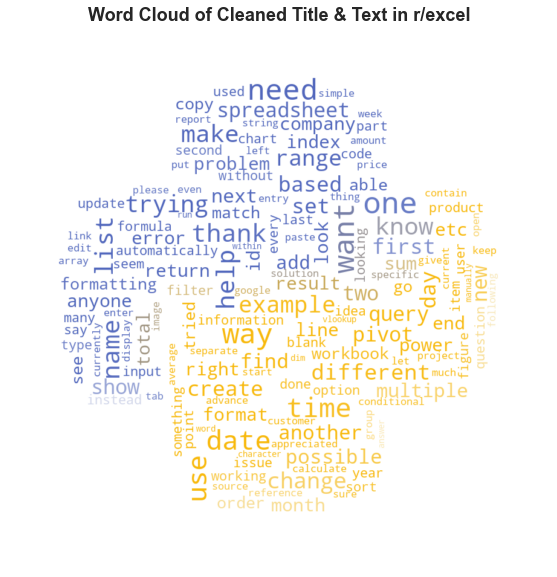

In [217]:
# word cloud for excel subreddit
excel_clean_df = train.loc[train['subreddit']==0]
excel_clean_text = " ".join(text for text in excel_clean_df.new_text)

# loading the excel logo as a mask
excel_mask = np.array(Image.open('../images/python.jpg'))
excel_mask.shape

wordcloud = WordCloud(max_font_size=50, 
                      max_words=150, 
                      background_color="white", 
                      mode="RGBA",
                      collocations=False, # only show single word grouping
                      mask=excel_mask).generate(excel_clean_text)
image_colors = ImageColorGenerator(excel_mask)
plt.figure(figsize =(10,10))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.title('Word Cloud of Cleaned Title & Text in r/excel', fontsize=18, fontweight='bold')
plt.axis("off")
plt.show()

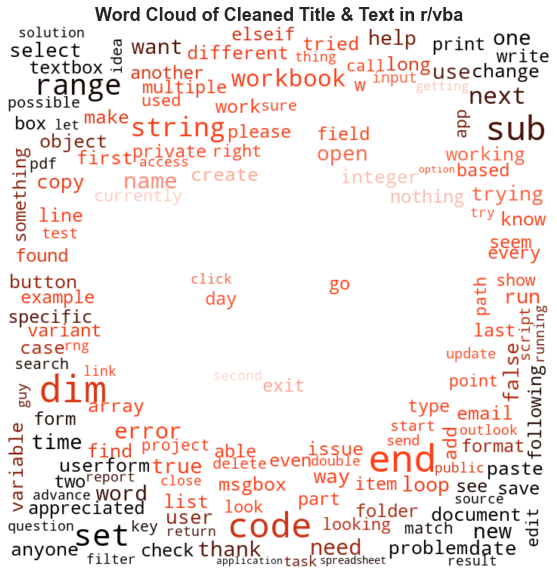

In [218]:
# word cloud for vba subreddit
vba_clean_df = train.loc[train['subreddit']==1]
vba_clean_text = " ".join(text for text in vba_clean_df.new_text)

# loading the excel logo as a mask
vba_mask = np.array(Image.open('../images/reddit.jpg'))

wordcloud = WordCloud(max_font_size=50, 
                      max_words=150, 
                      background_color="white", 
                      mode="RGBA", 
                      collocations=False, # only show single word grouping
                      mask=vba_mask).generate(vba_clean_text)
image_colors = ImageColorGenerator(vba_mask)
plt.figure(figsize =(10,10))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud of Cleaned Title & Text in r/vba', fontsize=18, fontweight='bold')
plt.show()

From the 2 word clouds, we see some words that are distinct and more common in each sub reddit.<br>

For example, in r/excel, we see common terms that we are familiar with in excel like 'index' (from index match function), 'pivot', 'sum'. <br>

On the other hand, in r/vba, we see some more specific vba type of word' like 'dim' which is the code to declare variable names in vba, 'end' to end the code execution, 'code', 'string', and 'script'. <br>



## Running Classifier Models on Default Settings

**Logistic Regression**

Logistic Regression uses something called a link function to effectively "bend" our line of best fit so that it is a curve of best fit that matches the range or set of values in which we're interested (excel = 0, vba = 1). For logistic regression, that specific link function that transforms ("bends") our line is known as the logit link, which then gives us the probabilities of being in each clas. We then use these probabilities to choose which class got predicted, ie less than 0.5, the predictions will be excel = 0, while more than 0.5 the predictions will be vba = 1. Probabilities at 0.5 will be randomly assigned to be either excel or vba. The coefficients are interpreted as log(odds) of predicting the positive class (vba).


In [219]:
#Instantiate logistic regression.
lr = LogisticRegression()

# Fit logistic regression.
lr.fit(X_train_cvec, y_train)

# Evaluate logistic regression.
print('Scoring based on Count Vectorizing:')
print(f'Log Reg Average Cross-Val-Score, 5-folds: {cross_val_score(lr, X_train_cvec, y_train, cv=5).mean()}')
print(f'Log Reg Training Score: {lr.score(X_train_cvec, y_train)}')
print(f'Log Reg Validation Score: {lr.score(X_valid_cvec, y_valid)}')
print()

lr = LogisticRegression()
lr.fit(X_train_tvec, y_train)

print('Scoring based on TF-IDF Vectorizing:')
print(f'Log Reg Average Cross-Val-Score, 5-folds: {cross_val_score(lr, X_train_tvec, y_train, cv=5).mean()}')
print(f'Log Reg Training Score: {lr.score(X_train_tvec, y_train)}')
print(f'Log Reg Validation Score: {lr.score(X_valid_tvec, y_valid)}')

Scoring based on Count Vectorizing:
Log Reg Average Cross-Val-Score, 5-folds: 0.7983050847457627
Log Reg Training Score: 0.9991525423728813
Log Reg Validation Score: 0.8244575936883629

Scoring based on TF-IDF Vectorizing:
Log Reg Average Cross-Val-Score, 5-folds: 0.8381355932203389
Log Reg Training Score: 0.9516949152542373
Log Reg Validation Score: 0.8422090729783037


Our Logistic Regression model has an 84.2% acurracy (82.4% when using cvec) in classifying vba and excel posts. However, we see that our training score of 95.2% (99.9% when using cvec) suggests that the model is very much overfitted to our training data.  

**Naive Bayes (Multinomial Bayes Classifier)**

The Naive Bayes classification algorithm is a classification modeling technique that relies on Bayes Theorem to predict the classes given the text in the post. Hence for any given post, Naive Bayes would compare the P(excel|post) vs P(vba|post) and assign the classification based on which probability is higher. Naive Bayes makes an important assumption that the words in the text are independent of one another, which might be restrictive given that texts tend to be dependent especially when looking in the context of a sentence (and not individual words).

In [220]:
# Instantiate Naive Bayes
nb = MultinomialNB()

# Fitting Naive Bayes.
nb.fit(X_train_cvec, y_train)

# Evaluate NB
print('Scoring based on Count Vectorizing:')
print(f'Naive Bayes Average Cross-Val-Score, 5-folds: {cross_val_score(nb, X_train_cvec, y_train, cv=5).mean()}')
print(f'Naive Bayes Training Score: {nb.score(X_train_cvec, y_train)}')
print(f'Naive Bayes Validation Score: {nb.score(X_valid_cvec, y_valid)}')
print()

nb = MultinomialNB()
nb.fit(X_train_tvec, y_train)
print('Scoring based on TF-IDF Vectorizing:')
print(f'Naive Bayes Average Cross-Val-Score, 5-folds: {cross_val_score(nb, X_train_tvec, y_train, cv=5).mean()}')
print(f'Naive Bayes Training Score: {nb.score(X_train_tvec, y_train)}')
print(f'Naive Bayes Validation Score: {nb.score(X_valid_tvec, y_valid)}')


Scoring based on Count Vectorizing:
Naive Bayes Average Cross-Val-Score, 5-folds: 0.8076271186440678
Naive Bayes Training Score: 0.9203389830508475
Naive Bayes Validation Score: 0.8284023668639053

Scoring based on TF-IDF Vectorizing:
Naive Bayes Average Cross-Val-Score, 5-folds: 0.8050847457627119
Naive Bayes Training Score: 0.9432203389830508
Naive Bayes Validation Score: 0.8027613412228797


Our Naive Bayes model has an 80.3% acurracy (82.8% when using cvec) in classifying vba and excel posts. Similarly, we see that our training score of 94.3% (92.0% when using cvec) suggests that the model is very much overfitted to our training data.  

**Random Forest & ExtraTrees**

A decision tree takes a dataset consisting of X and Y data and finds rules (usually based on a gini coefficient that measures the impurity of the split) based on our X data that partitions (splits) our data into smaller datasets such that by the bottom of the tree, the values Y in each "leaf node" are as "pure" as possible. However, decision trees alone tend to be grown very deep and become overfitted to the training data. 

To mitigate that, we could introduce bootstrapping (random sampling with replacement) so that we can generate another dataset from our original train dataset. If we were to generate multiple datasets based on bootstrapping then we have essentially used bagging (bootstrap aggregating) to expose different trees to different sub-samples of the training data. Thereafter, we can aggregate (average) the predictions for each model to obtain an overall prediction for the dataset that should theoretically be more robust than obtaining a single prediction based on 1 decision tree. 

However, with bagged decision trees, the multiple trees tend to be strongly correlated with one another, resulting in high variance similar to a single decision tree model. Random Forest & Extra Trees builds upon the idea of de-correlating decision trees from one another so that we can reduce the variances. Essentially, Random Forests use a modified tree learning algorithm that selects, at each split in the learning process, a random subset of the features. This process is sometimes called the random subspace method.

The reason for doing this is the correlation of the trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable (target output), these features will be used in many/all of the bagged decision trees, causing them to become correlated. By selecting a random subset of features at each split, we counter this correlation between base trees, strengthening the overall model.

Adding one more step of randomization (and thus de-correlation) yields extremely randomized trees, or ExtraTrees. These are trained using bagging (sampling of observations) and the random subspace method (sampling of features), but an additional layer of randomness is introduced. Instead of computing the locally optimal feature/split combination (based on, e.g., information gain or the Gini impurity) for each feature under consideration, a random value is selected for the split. This value is selected from the feature's empirical range. This further reduces the variance, but causes an increase in bias.

Since Random Forest & ExtraTrees are fundamentally more robust than a single decision tree model, we will use the default Random Forest and ExtraTrees model and not the decision tree model:

In [221]:
rf = RandomForestClassifier(n_estimators=100, max_features='auto', random_state=37) 
rf.fit(X_train_cvec, y_train)

# Evaluate RF
print('Scoring based on Count Vectorizing:')
print(f'Random Forest Average Cross-Val-Score, 5-folds: {cross_val_score(rf, X_train_cvec, y_train, cv=5).mean()}')
print(f'Random Forest Training Score: {rf.score(X_train_cvec, y_train)}')
print(f'Random Forest Validation Score: {rf.score(X_valid_cvec, y_valid)}')
print()

rf = RandomForestClassifier(n_estimators=100, max_features='auto', random_state=37) 
rf.fit(X_train_tvec, y_train)
print('Scoring based on TF-IDF Vectorizing:')
print(f'Random Forest Average Cross-Val-Score, 5-folds: {cross_val_score(rf, X_train_tvec, y_train, cv=5).mean()}')
print(f'Random Forest Training Score: {rf.score(X_train_tvec, y_train)}')
print(f'Random Forest Validation Score: {rf.score(X_valid_tvec, y_valid)}')

Scoring based on Count Vectorizing:
Random Forest Average Cross-Val-Score, 5-folds: 0.8288135593220339
Random Forest Training Score: 1.0
Random Forest Validation Score: 0.8382642998027613

Scoring based on TF-IDF Vectorizing:
Random Forest Average Cross-Val-Score, 5-folds: 0.8296610169491526
Random Forest Training Score: 1.0
Random Forest Validation Score: 0.8382642998027613


Our RandomForest Classifier model has an 83.8% acurracy for both tvec and cvec in classifying vba and excel posts. However, we see that our training score of 100% (for both tvec and cvec) suggests that the model is significantly overfitted to our training data.  

In [222]:
rf.feature_importances_

array([3.38553959e-05, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 4.73689445e-07, 4.82435654e-05])

In [223]:
et = ExtraTreesClassifier(n_estimators=100, max_features='auto', random_state=37)
et.fit(X_train_cvec, y_train)

# Evaluate ET
print('Scoring based on Count Vectorizing:')
print(f'Extra Trees Average Cross-Val-Score, 5-folds: {cross_val_score(et, X_train_cvec, y_train, cv=5).mean()}')
print(f'Extra Trees Training Score: {et.score(X_train_cvec, y_train)}')
print(f'Extra Trees Validation Score: {et.score(X_valid_cvec, y_valid)}')
print()

et = ExtraTreesClassifier(n_estimators=100, max_features='auto', random_state=37)
et.fit(X_train_tvec, y_train)
print('Scoring based on TF-IDF Vectorizing:')
print(f'Extra Trees Average Cross-Val-Score, 5-folds: {cross_val_score(et, X_train_tvec, y_train, cv=5).mean()}')
print(f'Extra Trees Training Score: {et.score(X_train_tvec, y_train)}')
print(f'Extra Trees Validation Score: {et.score(X_valid_tvec, y_valid)}')

Scoring based on Count Vectorizing:
Extra Trees Average Cross-Val-Score, 5-folds: 0.8203389830508474
Extra Trees Training Score: 1.0
Extra Trees Validation Score: 0.8441814595660749

Scoring based on TF-IDF Vectorizing:
Extra Trees Average Cross-Val-Score, 5-folds: 0.8288135593220339
Extra Trees Training Score: 1.0
Extra Trees Validation Score: 0.8382642998027613


Our RandomForest Classifier model has an 83.8% acurracy (84.4% when using cvec) in classifying vba and excel posts. Likewise, we see that our training score of 100% (for both tvec and cvec) suggests that the model is significantly overfitted to our training data.  

**Support Vector Machine**

A Support Vector Machine is a binary linear classifier whose decision boundary is explicitly constructed to minimize generalization error. The decision boundary is derived using geometric reasoning (as opposed to the algebraic reasoning we’ve used to derive other classifiers). The generalization error is equated with the geometric concept of margin, which is the region along the decision boundary that is free of data points.

In [224]:
# Instantiate support vector machine using default values first
svc = SVC()
svc.fit(X_train_cvec, y_train)

# Evaluate SVC
print('Scoring based on Count Vectorizing:')
print(f'Support Vector Machine Average Cross-Val-Score, 5-folds: {cross_val_score(svc, X_train_cvec, y_train, cv=5).mean()}')
print(f'Support Vector Machine Training Score: {svc.score(X_train_cvec, y_train)}')
print(f'Support Vector Machine Validation Score: {svc.score(X_valid_cvec, y_valid)}')
print()

svc = SVC()
svc.fit(X_train_tvec, y_train)
print('Scoring based on TF-IDF Vectorizing:')
print(f'Support Vector Machine Average Cross-Val-Score, 5-folds: {cross_val_score(svc, X_train_tvec, y_train, cv=5).mean()}')
print(f'Support Vector Machine Training Score: {svc.score(X_train_tvec, y_train)}')
print(f'Support Vector Machine Validation Score: {svc.score(X_valid_tvec, y_valid)}')

Scoring based on Count Vectorizing:
Support Vector Machine Average Cross-Val-Score, 5-folds: 0.8025423728813559
Support Vector Machine Training Score: 0.9330508474576271
Support Vector Machine Validation Score: 0.8303747534516766

Scoring based on TF-IDF Vectorizing:
Support Vector Machine Average Cross-Val-Score, 5-folds: 0.8347457627118644
Support Vector Machine Training Score: 0.9957627118644068
Support Vector Machine Validation Score: 0.8500986193293886


Our Support Vector Machine Classifier model has an 85.0% acurracy (83.0% when using cvec) in classifying vba and excel posts. Likewise, we see that our training score of 99.6% (93.3% in cvec) suggests that the model is also significantly overfitted to our training data.  

From the 5 models, we made the following observations:<br>

1. Our models generally overfit to our training data, such that the scoring on the validation set drops significantly, by as much as 0.205 points (20.5% accuracy) for logreg model.
2. Our TF-IDF vectorizer tends to do better than the Count Vectorizer. Hence, we will focus mainly on using tvec as our main vectorizer in our tuning of the hyper-parameers. 
3. Currently most of our models score within 0.82 - 0.84 for the validation set, with the Extra Trees Classifier (under tvec) scoring the highest (0.85). However, this is mainly due to the chosen random state (37), which yield a high score for the validation set. Setting other random states reduces the scoring back to the 0.82-0.84 range. 
<br>

We shall now tune our hyper-parameters with gridsearch and then select a production model based on our requirements:


## Tuning Hyper-Parameters and GridSearch 

With our initial 5 models, we introduce 2 more models to hypertune our parameters and try to see if this improves our accuracy scores and reduces our overfitting. <br>

The 2 new models are boosting models, which takes a weak base learner and try to make it a strong learner by retraining it on the misclassified samples. These models is an iterative procedure and can't be run in parallel and thus are generally slower to run when there are lots of different tunings. <br>

These models seek to:

- Assign weights to observations to indicate their "importance:" Samples with higher weights are given higher influence on the total error of the next model, prioritizing those observations.
- Weights change at each iteration with the goal of correcting the errors/misclassifications of the previous iteration: The first base estimator is fit with uniform weights on the observations.
- Final prediction is typically constructed by a weighted vote: Weights for each base model depend on their training errors or misclassification rates.

AdaBoost models fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as a single-split tree) on repeatedly modified versions of the data. After each fit, the importance weights on each observation need to be updated.

The predictions are then combined through a weighted majority vote (or sum) to produce the final prediction. AdaBoost, like all boosting ensemble methods, focuses the next model's fit on the misclassifications/weaknesses of the prior models.

As iterations continue, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence.

On the other hand, Gradient boosting classifiers train on the residuals (mis-classifications) of the first model and each subsequent models trains on the previous' residuals.<br>

As both AdaBoost and Gradient Boost work better with an initial weak model, we shall use the default decision tree classifier in our tuning:

In [225]:
# Let's set up pipelines of 7 models, including AdaBoosting and Gradient Boosting with TF-IDF Vectorizer:

pipe_1 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

pipe_2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_3 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=37))
])

pipe_4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier(random_state=37))
])

pipe_5 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svm', SVC())
])

pipe_6 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('gboost', GradientBoostingClassifier())
])

pipe_7 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ada', AdaBoostClassifier())
])

In [226]:
# setting the parameters for each pipe
param_range_fl = [3, 2, 1, 0.8] # used for the C in logreg and svm models, ant the alpha for Bayes

pipe_1_params = {
    'tvec__max_features': [3500, 4000, 4500, 4800, 5000, 5300, 5500],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.85, 0.88, 0.9, 0.95],
    'tvec__ngram_range': [(1, 2), (1, 3)],
    'lr__C': param_range_fl,
    'lr__solver': ['newton-cg', 'lbfgs']
}

pipe_2_params = {
    'tvec__max_features': [3500, 4000, 4500, 4800, 5000, 5300, 5500],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.85, 0.88, 0.9, 0.95],
    'tvec__ngram_range': [(1, 2), (1, 3)],
    'nb__alpha': param_range_fl,
}

pipe_3_params = {
    'tvec__max_features': [3800, 4000, 4200],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.85, 0.9],
    'tvec__ngram_range': [(1, 2), (1, 3)],
    'rf__n_estimators': [80, 100, 120],
    'rf__criterion': ['entropy'],
    'rf__max_depth': [None, 1, 2],
    'rf__min_samples_split': [2, 4],
}


pipe_4_params = {
    'tvec__max_features': [4500, 4800, 5000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.85, 0.9],
    'tvec__ngram_range': [(1, 2), (1, 3)],
    'et__n_estimators': [80, 100, 120],
    'et__criterion': ['entropy'],
    'et__max_depth': [None, 1, 2],
    'et__min_samples_split': [2, 4, 6],
}

pipe_5_params = {
    'tvec__max_features': [3800, 4000, 4200],
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.70, 0.72, 0.75],
    'tvec__ngram_range': [(1, 3), (1, 4)],
    'svm__C': param_range_fl,
    'svm__kernel': ['rbf', 'linear'],
}

pipe_6_params = {
    'tvec__max_features': [4000, 4300],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.85, 0.9],
    'tvec__ngram_range': [(1, 2), (1, 3)],
    'gboost__learning_rate': [0.08, 0.1],
    'gboost__n_estimators': [80, 100],
    'gboost__subsample': [0.9, 0.95],
    'gboost__max_depth': [2, 3],
}

pipe_7_params = {
    'tvec__max_features': [4000, 4300, 4500, 4800],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.80, 0.85, 0.9],
    'tvec__ngram_range': [(1, 2), (1, 3)],
    'ada__n_estimators': [35, 40, 45],
    'ada__learning_rate': [0.6, 0.7, 0.8, 0.9, 1],
} 

In [227]:
# setting up the grid searches

gs_1 = GridSearchCV(estimator = pipe_1,
                    param_grid = pipe_1_params,
                    cv = 5,
                    verbose = 1)

gs_2 = GridSearchCV(estimator = pipe_2,
                    param_grid = pipe_2_params,
                    cv = 5,
                    verbose = 1)

gs_3 = GridSearchCV(estimator = pipe_3,
                    param_grid = pipe_3_params,
                    cv = 5,
                    verbose = 1)

gs_4 = GridSearchCV(estimator = pipe_4, 
                    param_grid = pipe_4_params,
                    cv = 5, 
                    verbose = 1)

gs_5 = GridSearchCV(estimator = pipe_5, 
                    param_grid = pipe_5_params,
                    cv = 5, 
                    verbose = 1)

gs_6 = GridSearchCV(estimator = pipe_6, 
                    param_grid = pipe_6_params,
                    cv = 5, 
                    verbose = 1)

gs_7 = GridSearchCV(estimator = pipe_7, 
                    param_grid = pipe_7_params,
                    cv = 5, 
                    verbose = 1)

In [228]:
grids = [gs_1, gs_2, gs_3, gs_4, gs_5, gs_6, gs_7]

grid_dict = {0: 'Logistic Regression', 1: 'Multinomial Bayes', 
             2: 'Random Forest', 3: 'Extra Trees',
             4: 'Support Vector Machine', 5: 'Gradient Boosting',
             6: 'Ada Boosting'
            }

In [229]:
for idx, gs in enumerate(grids):
    print(f'\nGridsearch on Estimator: {grid_dict[idx]}')
    
    # Fit grid search
    gs.fit(X_train, y_train)
    
    # showing best params
    print(f'Best params: {gs.best_params_}')
    
    # Best training score
    print(f'Best training accuracy: {round(gs.best_score_, 3)}')
    
    # Scoring on validation data with best params
    print(f'Validation accuracy: {gs.score(X_valid, y_valid)}')
    
    # Printing Confusion Matrix and Scoring reports
    print()
    print(f'Confusion Matrix for: {grid_dict[idx]}')
    print(confusion_matrix(y_valid, gs.predict(X_valid)))
    print()
    print(f'Scoring Report for: {grid_dict[idx]}')
    print(classification_report(y_valid, gs.predict(X_valid)))


Gridsearch on Estimator: Logistic Regression
Fitting 5 folds for each of 896 candidates, totalling 4480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 4480 out of 4480 | elapsed: 25.2min finished


Best params: {'lr__C': 1, 'lr__solver': 'newton-cg', 'tvec__max_df': 0.85, 'tvec__max_features': 5000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}
Best training accuracy: 0.84
Validation accuracy: 0.8422090729783037

Confusion Matrix for: Logistic Regression
[[190  36]
 [ 44 237]]

Scoring Report for: Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       226
           1       0.87      0.84      0.86       281

    accuracy                           0.84       507
   macro avg       0.84      0.84      0.84       507
weighted avg       0.84      0.84      0.84       507


Gridsearch on Estimator: Multinomial Bayes
Fitting 5 folds for each of 448 candidates, totalling 2240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2240 out of 2240 | elapsed:  9.8min finished


Best params: {'nb__alpha': 1, 'tvec__max_df': 0.85, 'tvec__max_features': 4800, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}
Best training accuracy: 0.831
Validation accuracy: 0.8362919132149902

Confusion Matrix for: Multinomial Bayes
[[178  48]
 [ 35 246]]

Scoring Report for: Multinomial Bayes
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       226
           1       0.84      0.88      0.86       281

    accuracy                           0.84       507
   macro avg       0.84      0.83      0.83       507
weighted avg       0.84      0.84      0.84       507


Gridsearch on Estimator: Random Forest
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2160 out of 2160 | elapsed: 16.7min finished


Best params: {'rf__criterion': 'entropy', 'rf__max_depth': None, 'rf__min_samples_split': 4, 'rf__n_estimators': 80, 'tvec__max_df': 0.85, 'tvec__max_features': 4000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}
Best training accuracy: 0.842
Validation accuracy: 0.8382642998027613

Confusion Matrix for: Random Forest
[[195  31]
 [ 51 230]]

Scoring Report for: Random Forest
              precision    recall  f1-score   support

           0       0.79      0.86      0.83       226
           1       0.88      0.82      0.85       281

    accuracy                           0.84       507
   macro avg       0.84      0.84      0.84       507
weighted avg       0.84      0.84      0.84       507


Gridsearch on Estimator: Extra Trees
Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3240 out of 3240 | elapsed: 25.4min finished


Best params: {'et__criterion': 'entropy', 'et__max_depth': None, 'et__min_samples_split': 6, 'et__n_estimators': 100, 'tvec__max_df': 0.85, 'tvec__max_features': 5000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}
Best training accuracy: 0.841
Validation accuracy: 0.8658777120315582

Confusion Matrix for: Extra Trees
[[204  22]
 [ 46 235]]

Scoring Report for: Extra Trees
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       226
           1       0.91      0.84      0.87       281

    accuracy                           0.87       507
   macro avg       0.87      0.87      0.87       507
weighted avg       0.87      0.87      0.87       507


Gridsearch on Estimator: Support Vector Machine
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 17.3min finished


Best params: {'svm__C': 0.8, 'svm__kernel': 'rbf', 'tvec__max_df': 0.7, 'tvec__max_features': 4000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 4)}
Best training accuracy: 0.84
Validation accuracy: 0.8500986193293886

Confusion Matrix for: Support Vector Machine
[[195  31]
 [ 45 236]]

Scoring Report for: Support Vector Machine
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       226
           1       0.88      0.84      0.86       281

    accuracy                           0.85       507
   macro avg       0.85      0.85      0.85       507
weighted avg       0.85      0.85      0.85       507


Gridsearch on Estimator: Gradient Boosting
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed: 27.1min finished


Best params: {'gboost__learning_rate': 0.08, 'gboost__max_depth': 3, 'gboost__n_estimators': 80, 'gboost__subsample': 0.95, 'tvec__max_df': 0.9, 'tvec__max_features': 4300, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}
Best training accuracy: 0.813
Validation accuracy: 0.8362919132149902

Confusion Matrix for: Gradient Boosting
[[211  15]
 [ 68 213]]

Scoring Report for: Gradient Boosting
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       226
           1       0.93      0.76      0.84       281

    accuracy                           0.84       507
   macro avg       0.85      0.85      0.84       507
weighted avg       0.85      0.84      0.84       507


Gridsearch on Estimator: Ada Boosting
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed: 48.2min finished


Best params: {'ada__learning_rate': 0.6, 'ada__n_estimators': 35, 'tvec__max_df': 0.8, 'tvec__max_features': 4000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 3)}
Best training accuracy: 0.814
Validation accuracy: 0.8264299802761341

Confusion Matrix for: Ada Boosting
[[202  24]
 [ 64 217]]

Scoring Report for: Ada Boosting
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       226
           1       0.90      0.77      0.83       281

    accuracy                           0.83       507
   macro avg       0.83      0.83      0.83       507
weighted avg       0.84      0.83      0.83       507



## Best Model Selection and Evaluation

Referring back to our main problem, we would like to reduce the number of instances where a post which is actually about VBA being posted as an Excel query. In essence, we would like to reduce the number of False Negatives. The model that has the least False Negatives is the Multinomial Bayes model with only 35 false negatives. <br>

Although the Multinomial Bayes model has a validation accuracy score of only 83.6% (and traning accuracy of 83.1%), It has the least False Negatives out of the 7 models we ran. Additionally, the model generalized well to the validation set and suffered no underfitting. <br>

The best parameters under the Multinomial Bayes model are:
1. tvec_max_df = 0.85: This is a parameter that removes terms that appear too frequently across every document. In this case, the model removes terms that appear in more than 85% of the documents

2. tvec_min_df = 2: Conversely, this is a parameter that removes terms that appear very infrequently. In this case, the model removes terms that appear in less than 2 documents (ie, terms that only appear in 1 document)

3. tvec_max_features = 4800: Compared to our original corpus of 6966 columns (features), the maximum features used in the model was 4800. This should be the primary reason why our model is now not overfitted to the training dataset. 

4. tvec_ngram_range = (1,3): This lets the model consider sequential word groupings of up to trigrams, that means, 3 consecutive words in a sentence can be considered as 1 feature if it helps in our classification models. 

5. nb_alpha = 1 (which happens to be the default): Alpha is the additive (Laplace/Lidstone) smoothing parameter. As Naive Bayes classifies the categories based on conditional probability, specifically probability of a word appearing in the text given that it is in category = 0, multiplied by all the conditional probabilities of all the words and dividing by the probability of the word appearing for that datapoint. Should any one of the words in the corpus not appear, then the conditional probability will be 0 and the whole equation would be 0, which will happen a lot of the time since we do not expect each datapoint to contain all the words in our corpus. Hence, alpha is needed to smooth the probability such that it does not become exactly 0 and a probability can still be derived. 

Lastly, comparing to our baseline accuracy of 55.4%, our Naive Bayes model accuracy of 83.6% is 28.2 percentage points better.<br>

Next, let's look at the top predictive words for each class:

**Top Predictive Words**

In [230]:
class_labels = gs_2.best_estimator_.named_steps['nb'].classes_
feature_names = gs_2.best_estimator_.named_steps['tvec'].get_feature_names()

coefs = gs_2.best_estimator_.named_steps['nb'].coef_[0]
top_350_excel = sorted(zip(coefs, feature_names))[:350]
top_30_vba = sorted(zip(coefs, feature_names))[-30:]

In [231]:
# As the top predictive words had the same probability until the ~350th word 
# it was sorted by alphabetical order
# we call the top 350 words instead
print('Top 30 features for predicting Excel class:')
print()
for coef, feat in top_350_excel:
    print(round(coef,3), feat)

Top 30 features for predicting Excel class:

-9.055 able enter
-9.055 accomplish
-9.055 age
-9.055 aggregate
-9.055 aid
-9.055 allocation
-9.055 allowance
-9.055 analysis toolpak
-9.055 another example
-9.055 another page
-9.055 answer rounded
-9.055 area chart
-9.055 asap
-9.055 assistant
-9.055 automatically calculate
-9.055 bar chart
-9.055 barcodes
-9.055 basic formula
-9.055 basically date
-9.055 beyond
-9.055 bit help
-9.055 border
-9.055 bucket
-9.055 calculate total
-9.055 cant seem
-9.055 case need
-9.055 change update
-9.055 character length
-9.055 chart based
-9.055 chart display
-9.055 classroom
-9.055 click wheel
-9.055 clock
-9.055 clustered
-9.055 combining
-9.055 company company
-9.055 computer run
-9.055 concatenate
-9.055 conditional formatting based
-9.055 conditional formatting rule
-9.055 considering
-9.055 consistently
-9.055 consists
-9.055 contains information
-9.055 copy whole
-9.055 correct duration
-9.055 count every
-9.055 countifs
-9.055 create calculated
-

In [232]:
print('Top 30 features for predicting VBA class:')
print()
for coef, feat in top_30_vba:
    print(round(coef,3), feat)

Top 30 features for predicting VBA class:

-6.768 add
-6.756 document
-6.756 date
-6.72 true
-6.704 one
-6.702 trying
-6.683 get
-6.681 way
-6.679 need
-6.676 open
-6.653 copy
-6.649 want
-6.649 new
-6.631 time
-6.631 use
-6.608 run
-6.593 loop
-6.58 name
-6.566 end sub
-6.537 next
-6.49 word
-6.42 error
-6.351 workbook
-6.346 string
-6.033 set
-5.954 range
-5.82 sub
-5.807 dim
-5.765 end
-5.697 code


Similar to the word clouds, we see familiar words for excel that are in the top 350 predictive words. For example, 'analysis toolpak', 'countifs', 'power pivot', 'sumifs', 'make chart' etc which are specific to excel itself. <br>

On the other hand, top predictive words in vba tends to be unigrams, and also shorter in character length like 'dim', 'end', 'code', 'true', 'run'. Similarly, they are specific to vba itself. 

Let's proceed to analysis why some of the texts got mis-classified. Recall that we are mainly focused on minimizing False Negatives, hence we will focus on those texts that were vba but were predicted to be excel:

In [233]:
predictions = gs_2.predict(X_valid)
df = pd.DataFrame(X_valid, columns=['new_text'])
df['actual'] = y_valid
df['predicted'] = predictions

In [234]:
df

new_text  actual  predicted
1055  memory know problem easy fix microsoft office ...       1          0
811   change based another cannot wrap brain around ...       1          0
1032  disucssion opening worm one time people hate u...       1          1
1103  range working sumifs get syntax right range le...       1          1
630   query whole query bringing extra blank one sou...       0          0
1591  runtime error able save generated chosen share...       1          1
506   use button advance date one next calculate day...       0          0
1226  vlookup object problem line code giving run ti...       1          1
1194  serve specific range picture copy paste signat...       1          1
991   code identifies downloads folder need add way ...       1          1
1391  looping object set amount time code loop email...       1          1
859   word document delay really needed advice regar...       1          1
1361  quiz buzzer guy want make quiz problem userfor...       1          1
1384  replace word m word research found way replace...       1          1
1171  print push button print setup print preview pr...       1          1
296   transfer comment another update automatically ...       0          1
361   say problem im trying make small program check...       0          1
782   late binding date picker user form everyone bu...       1          1
1640  date calculation working reason loop missing r...       1          1
33    compatibility version prevalence question repo...       0          0
1314  possible grab current gps coordinate via possi...       1          0
963   combining multiple script word hey fella close...       1          1
1579  use statement read statement microsoft website...       1          1
619   trying count often variable occurs within date...       0          0
142   three line address formatted fine appears one ...       0          1
1508   autocad much differ harder done loke try autocad       1          1
434   stack transition google linked form trying fin...       0          0
378   create graph multiple factor essentially facto...       0          0
272   possible give right person viewing one workboo...       0          0
1298  format textbox allow typing formatted textbox ...       1          1
1036  workaround custom die save new copy probably t...       1          1
827   filter multiple pivotitems dim myarray variant...       1          1
1099  handle outlook limit recipient single mail bas...       1          1
762   format date application inputbox ask user ente...       1          1
570   formatting csv retain usually said csvs retain...       0          0
51    copying one filtered list pasting back origina...       0          0
967   check user sharepoint run code need automate p...       1          1
756   access query linked via odbc regular user acce...       1          0
254   guidance finding organizing date description p...       0          0
370   return looking image left one right another in...       0          0
505   attempting create toggle option choice change ...       0          0
988   want make code nice little loop sub mt mt mt m...       1          1
217   fill list information multiple checkboxes affe...       0          0
927   remove duplicate remove empty title work immed...       1          1
375   creating packing label shopify order want crea...       0          0
652   sparklines updating first time sparklines supp...       0          0
299   create reference multiple older name different...       0          1
745   given korean spread default encoding display k...       0          1
1595  loop though one two dimensional named range na...       1          1
1541  outlook search people email address outlook ba...       1          1
1436  userform eomonth userinput year month output z...       1          1
658   suggestion required creation single database c...       0          1
587   pivot market interpretation recently started r...       0         

In [235]:
df.loc[(df['actual']== 1) & (df['predicted']==0)]

new_text  actual  predicted
1055  memory know problem easy fix microsoft office ...       1          0
811   change based another cannot wrap brain around ...       1          0
1314  possible grab current gps coordinate via possi...       1          0
756   access query linked via odbc regular user acce...       1          0
1516  college hey guy completely new world want mast...       1          0
851   changing pivot chart ax pivot chart created po...       1          0
1317  bulk historic efficient way identify move list...       1          0
774   best practice forking ongoing project newish w...       1          0
1415  outline pane presentation view showing differe...       1          0
1256  microsoft filter loader crashing application c...       1          0
1014  copy specific master several based criterion t...       1          0
1093  looking start knowledge skill side hustle star...       1          0
1686  m word dropdown list image word doc use report...       1          0
1203  im h student specialty learning early age wort...       1          0
980   getting sum certain pivot apology vague title ...       1          0
1140  creating dynamic list add new bottom please he...       1          0
994   removing space day date numebr seem get workin...       1          0
837   update mastermind game built hey guy last week...       1          0
1249  code stock looking code link spreadsheet get s...       1          0
1008  check bar change event hey guy made minesweepe...       1          0
1609  return page filter selection olap pivot trying...       1          0
1372  recurrent cumulative clear beginner use month ...       1          0
889   assign hotkeys personal xlsb title say want as...       1          0
934   know fast way redimension array way majority u...       1          0
861   factset altermative fdsforcerecalc refreshing ...       1          0
845   able run mobile device smartphones tablet ask ...       1          0
1445  dropdown list based another hey guy really nee...       1          0
791   hide title bar dashboard working dashboard wan...       1          0
1069  insert active copy formula wizzards new want c...       1          0
773   possible predictive modelling example trying p...       1          0
1330  splitting large set multiple looking suggestio...       1          0
1276  error recognize tab name opened working month ...       1          0
938   match hopefully explain say give take thousand...       1          0
1414  trustworthy always return current date time as...       1          0
1173  book written ressources sharpen improve code g...       1          0

In [236]:
X_valid.loc[1055]

'memory know problem easy fix microsoft office used code copy multiple one power query long vary anywhere anything special mostly header one name however whenever try constantly run memory issue freeze could actual project working requires copy edit try explain best process copy list song song id website copy list song song level numeric different website merge based song title song id song title song level song however list player attempted song score process song level equal certain level let say level count many score higher many score higher many score higher write song labeled level calculate involving another issue song level seldomly change blue moon level song suddenly rerated level song edit error happening compiling happening grabbed try anything grabbed get error'

In [237]:
train['title_text'].loc[1055]

'out of memory So I don\'t know if this a problem that is an easy fix...\n\n&amp;#x200B;\n\nThis is for Microsoft Office 365 Excel. I used a VBA code to copy multiple tables (like 70 or so) on one worksheet using power query. Each table is 10 columns long and the rows vary from table to table but it\'s anywhere from 800 to 1600. Each table themselves aren\'t anything special, it\'s mostly numbers and a header, with one column having names.\n\nHowever, whenever I try to work on this I constantly run into a "Out of Memory" issue, and it freezes up. What could I do? The actual project I\'m working on requires me to copy over 800+ tables.\n\n&amp;#x200B;\n\nEDIT: I\'ll try to explain the best I can on my process.\n\n1. Copy a list of songs with their 800 song ids from the website.\n2. Copy a list of 800 songs with their song levels (numeric value) from a different website.\n3. Merge them based off the song title.\n\nNow we have a table with song id, the song title, and the song levels .\n\

Recall from our earlier analysis on the word frequency (word clouds) and the top predictors for each class that vba words then to be more technical while excel words tend to be simplier. Excel posts tend to be more descriptive rather than technical like with function names. <br>

For this text, the clean version was generally very descriptive although it has 2 words ('code' and 'copy') that were highly predictive for the vba class. 

In [238]:
X_valid.loc[851]

'changing pivot chart ax pivot chart created power pivot model want write change ax date field month field calendar trouble assigning axis object figuring method use change chart show month instead date'

In [239]:
train['title_text'].loc[851]

'changing pivot chart axes. I have a pivot chart I created from my power pivot data model. I want to write a macro to change the axes from the “date” field to the “month” field on the calendar table. I’m having trouble assigning the axis object and figuring out which method to use to change this so the chart shows data by month instead of by date.'

This was perhaps one of the more difficult to predict as the cleaned text mainly showed excel type wordings like pivot, date, assign, create and the author just wanted a relatively simple macro to solve his issue. 

In [240]:
X_valid.loc[811]

'change based another cannot wrap brain around use change based another example xyz use abc use thinking put formula another use vlookup get use xyz abc part cannot figure get ie help appreciated thanks'

In [241]:
train['title_text'].loc[811]

'change excel formula based on another cell I cannot wrap my brain around how to use VBA to change the formula based on a value in another cell.  For example, if cell A1 = \'XYZ\', use formula "=B1+C1".  If cell A1 = \'ABC", use formula "=B1+D1".\n\nI was thinking I would put the formulas in another sheet and use VLOOKUP to get the formula to use\n\nXYZ     "=B+C"\n\nABC    ="B+D"\n\nThe part I cannot figure out is how to get the row numbers into the formula using VBA (ie, =B1+C1")\n\nAny help would be appreciated.\n\nThanks.'

Similarly, this had relatively simple text and the word 'vlookup' which probably was the key word that made it got predicted as excel.

In [242]:
X_valid.loc[1445]

'dropdown list based another hey guy really need advice done google literally found nothing relevant need much people use drop list basically need create dropdown list item list get added removed dynamically based another rough example item dropdown list referenced item adjacent greater item adjacent must shown dropdown list item adjacent must excluded dropdown list hence item removed dropdown list reach remaining affected tried good neither google useful excuse provide existing code worked managed formula ended removing last every time instead hence success'

In [243]:
train['title_text'].loc[1445]

'excel dropdown list based on another cell’s value Hey guys, I really need any advice here!\n\nI’ve done with google but literally found nothing relevant for what I need. It’s like not much people use drop down list.\n\n\nSo basically I need to create a dropdown list for excel that the items in the list gets added and removed dynamically based on another cell’s value. Here is a rough example:-\n\nITEM        NUMBER\n\n    A                 10\n\n    B                  4\n\n    C                  0\n\n    D                  1\n\nIt’s on table.\n\n\nThe DropDown list is referenced to the ITEM column and if the values in the adjacent column NUMBER is greater than 0 the ITEM adjacent to it must be shown in DropDown list. \n\nand ITEM with value 0 in it’s adjacent NUMBER column must be excluded from the DropDown list, \n\nHence ITEM C should be removed from the DropDown List once it reaches 0 and the remaining A B D will not be affected. \n\n\nI’ve tried VBA but I’m not good at it and neith

Likewise, words like 'example' and non-technical texts was probably the reason it got predicted as excel. 

In [244]:
X_valid.loc[1173]

'book written ressources sharpen improve code guy coding macro year finance automated many process get even better regard code performance code debugging datastructures probably going involved higher level project huge reconciliation project calculation etc proficient python sure use project hassle deploy since project focused prefer sharpen knowledge book suggest go intermediate advanced kind regard'

In [245]:
train['title_text'].loc[1173]

"what books/written ressources to sharpen and improve my excel vba code? Hi guys,  \n\nBeen coding VBA macros for 3 years now, i work in finance and automated many processes with it. But i'd like to get even better in regards to code performance, code debugging, datastructures, as i'm probably going to be involved in some higher level projects (Huge reconciliations projects, calculations etc...)  \n\nI'm proficient in Python too but i'm not sure if i should use it for this projects as it is a hassle to deploy. Since all the projects are Excel focused, i prefer to sharpen my VBA knowledge.  \n\nSo what books do you suggest to go from intermediate to advanced?  \n\nKinds regards,"

As we can see, posts that are mis-classified as excel had texts that do not contain a lot of technical words in the cleaned versions. 

## Conclusion & Post Evaluation

Recalling our initial premise where we would like to minimize the classification of actual vba posts as excel, Is there any way to further improve our best model?<br>

In our cleaning of the text, we deliberately removed instances of 'vba' and 'excel' so that we can train the model on other keywords. Supposed we retain 'vba' in texts that do have them, will our overall classification improve? 

Furthermore, in our default tests, we note that the Multinomial Bayes model actually performed better with cvec. Hence, let's re-clean our initial text and run our Multinomial Bayes model on both tvec and cvec to see if our results improved:

In [246]:
# the code is mostly the same but 'vba' keyword is retained in text that have them
def experiment_text(raw_text):
    # Function to convert a raw text to a string of words
    # The input is a single string and 
    # the output is a single string (a preprocessed sub reddit text)
    
    # 1. convert text to lower case
    lower_text = raw_text.lower()
    
    # 2. Remove HTML type chars
    review_text = BeautifulSoup(lower_text).get_text()
     
    # 3. Remove http(s) type strings
    review_text = re.sub("http.\S+", " ", review_text)
    
    # 4. Remove pointer reference and zero-width spaces
    review_text = re.sub("[&]\S+", " ", review_text)
    
    # 5. removing \xa0 reference
    review_text = re.sub("\\xa0", " ", review_text)
    
    # 6. removing reference to excel
    review_text = re.sub("excel", " ", review_text)
    
    # 7. removing new line reference
    review_text = re.sub("\\n", " ", review_text)
    
    # 8. removing long words reference (more than 15 char)
    review_text = re.sub("[\S]{15}\S+", " ", review_text)
        
    # 9. removing non-char non-num reference and all numbers
    review_text = re.sub("([^a-z])|([\d])", " ", review_text)
    
    # 10. removing standalone characters and multiple spaces
    review_text = re.sub("(^| ).(( ).)*( |$)", " ", review_text)
    
    # 11. Split into individual words.
    words = review_text.split()
    
    # 12. Using stopwords and user-defined words that are common across the 2 reddits
    stops = stopwords.words('english')
    new_words = ['column', 'columns', 'rows', 'row', 'cell', 'cells', 
                 'data', 'formula', 'worksheets', 'worksheet', 'values', 'value', 
                 'sheet', 'sheets', 'table', 'tables', 'macro', 'work', 
                 'hi', 'hello', 'file', 'files', 'number', 'numbers', 
                 'texts', 'text', 'using', 'would', 'like', 'function', 
                 'functions']
    stops.extend(new_words)
    meaningful_words = [w for w in words if w not in stops]
    
    # 13. Lemmatizing
    meaningful_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    
    # 14. Join the words back into one string separated by space
    return(" ".join(meaningful_words))

In [247]:
train['experiment_text'] = train['title_text'].apply(lambda x: experiment_text(x))

In [248]:
y_exp = train['subreddit']
X_exp = train['experiment_text']

In [249]:
X_exp_train, X_exp_valid, y_exp_train, y_exp_valid = train_test_split(X_exp, 
                                                                      y_exp, 
                                                                      test_size=0.3, 
                                                                      random_state=37, 
                                                                      stratify=y_exp)

In [250]:
# setting 2 pipelines running tvec and cvec
pipe_exp1 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_exp2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_exp1_params = {
    'tvec__max_features': [3500, 3800, 4000],
    'tvec__min_df': [2, 3, 4],
    'tvec__max_df': [0.75, 0.78, 0.8],
    'tvec__ngram_range': [(1, 2), (1, 3)],
    'nb__alpha': [0.5, 0.8, 1, 1.5]
    }

pipe_exp2_params = {
    'cvec__max_features': [5500, 5700, 5800, 6000],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [0.73, 0.75, 0.78, 0.8],
    'cvec__ngram_range': [(1, 2), (1, 3)],
    'nb__alpha': [0.8, 1, 1.5, 1.8, 2]
    }

In [251]:
gs_exp1 = GridSearchCV(estimator = pipe_exp1,
                       param_grid = pipe_exp1_params,
                       cv = 5,
                       verbose = 1)

gs_exp2 = GridSearchCV(estimator = pipe_exp2,
                       param_grid = pipe_exp2_params,
                       cv = 5,
                       verbose = 1)

In [252]:
grids_exp = [gs_exp1, gs_exp2]

grid_exp_dict = {0: 'Multinomial Bayes with tvec', 1: 'Multinomial Bayes with cvec'}

In [253]:
for idx, gs_exp in enumerate(grids_exp):
    print(f'\nGridsearch on Estimator: {grid_exp_dict[idx]}')
    
    # Fit grid search
    gs_exp.fit(X_exp_train, y_exp_train)
    
    # showing best params
    print(f'Best params: {gs_exp.best_params_}')
    
    # Best training score
    print(f'Best training accuracy: {round(gs_exp.best_score_, 3)}')
    
    # Scoring on validation data with best params
    print(f'Validation accuracy: {gs_exp.score(X_exp_valid, y_exp_valid)}')
    
    # Printing Confusion Matrix and Scoring reports
    print()
    print(f'Confusion Matrix for: {grid_exp_dict[idx]}')
    print(confusion_matrix(y_exp_valid, gs_exp.predict(X_exp_valid)))
    print()
    print(f'Scoring Report for: {grid_exp_dict[idx]}')
    print(classification_report(y_exp_valid, gs_exp.predict(X_exp_valid)))


Gridsearch on Estimator: Multinomial Bayes with tvec
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:  5.8min finished


Best params: {'nb__alpha': 1, 'tvec__max_df': 0.75, 'tvec__max_features': 3500, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}
Best training accuracy: 0.848
Validation accuracy: 0.8757396449704142

Confusion Matrix for: Multinomial Bayes with tvec
[[186  40]
 [ 23 258]]

Scoring Report for: Multinomial Bayes with tvec
              precision    recall  f1-score   support

           0       0.89      0.82      0.86       226
           1       0.87      0.92      0.89       281

    accuracy                           0.88       507
   macro avg       0.88      0.87      0.87       507
weighted avg       0.88      0.88      0.88       507


Gridsearch on Estimator: Multinomial Bayes with cvec
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed: 11.2min finished


Best params: {'cvec__max_df': 0.73, 'cvec__max_features': 5700, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'nb__alpha': 1.8}
Best training accuracy: 0.853
Validation accuracy: 0.8560157790927022

Confusion Matrix for: Multinomial Bayes with cvec
[[211  15]
 [ 58 223]]

Scoring Report for: Multinomial Bayes with cvec
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       226
           1       0.94      0.79      0.86       281

    accuracy                           0.86       507
   macro avg       0.86      0.86      0.86       507
weighted avg       0.87      0.86      0.86       507



Surprisingly, our tvec does better than cvec, different from the default model we ran initially. More interestingly, we were able to reduce the number of false negatives to 23, a decline of 12 postings, or an approximate 34% reduction from the original 35 false negatives. This is perhaps due to the model being able to better recognize and classify vba posts due to the addition of this keyword and thus reduce our overall False Negative numbers.   